<h2><center><h1><center><font color='Red'> Lending <font color='Blue'> Club <font color='DarkOrange'> Case <font color='Green'> Study

<h4><center> By <br><br>
Farooq Ahmed,MSc IBF(Liverpool JMU), MBA (City London), EPAT <br>
email <font color='Blue'>Farooqams@hotmail.com<font color='Blue'>

# Objective of the Assignement 

### The assignement required the use of  EDA to understand how consumer attributes and loan attributes influence the tendency of default.
### The company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. 
### The results of significant univariate, bivariate analysis in business terms, will be provided.

### We will approach the problem by directly assessing the significant drivers and identifying the problem by Pythonic way, reducing duplcating task.


<h5><center>Sept 2021

# Import Library

We import following libraries 

In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')

import datetime ## download to convert loan formating
import numpy as np 
import pandas as pd


import seaborn as sns ## download for using rich sea-born theme 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
#sns.set_style('white') 
#sns.color_palette("rocket", as_cmap=True)
#sns.light_palette("green", as_cmap=True)
#plt.rcParams['font.family'] = 'serif'
#plt.style.use('seaborn-bright')
%matplotlib inline

import os

# Diable limit of display
#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', 30)
#pd.options.display.float_format = "{:,.2f}".format ## This libary parameter is downloaded keep the loan in Notional Decimal.

from IPython.display import display, HTML

#import colorama
#from colorama import Fore, Style

from scipy.stats import norm

Wall time: 1.7 s


# Cleaning and Manipulation (20%)

In [2]:
loan = pd.read_csv('loan.csv',encoding = "ISO-8859-1",parse_dates=True)#.fillna(0) 

In [3]:
loan.columns[2:5]

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv'], dtype='object')

In [4]:
display(loan.head(1))

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  

[1 rows x 111 columns]

### From the Above table based on our experience and research in credit risk, we decided to use following minimum key variables

Univariate Analysis will be based on distribution : loan_amnt,funded_amnt, installment, emp_length

Segmented Univariate Analysis will be based on scatterplot, barchart : funded_amnt to compare with int_rate, term, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, 

Business-driven, Type-driven and loan-driven metrics : We will create some columns to see time-series impact.

In [5]:
display(loan.head(2).T)

0        1
id                          1077501  1077430
member_id                   1296599  1314167
loan_amnt                      5000     2500
funded_amnt                    5000     2500
funded_amnt_inv              4975.0   2500.0
...                             ...      ...
tax_liens                       0.0      0.0
tot_hi_cred_lim                 NaN      NaN
total_bal_ex_mort               NaN      NaN
total_bc_limit                  NaN      NaN
total_il_high_credit_limit      NaN      NaN

[111 rows x 2 columns]

### We noted column 47 onward are not important column, hence we drop them from the loan. 

In [6]:
empty_cols = [i for i in range(47,111)] 
loan = loan.drop(loan.columns[empty_cols],axis=1)

### Further we will remove additional columns which are blank or not important within the loanset

In [7]:
round(loan.isnull().sum()/len(loan.index), 2)*100

id                          0.0
member_id                   0.0
loan_amnt                   0.0
funded_amnt                 0.0
funded_amnt_inv             0.0
term                        0.0
int_rate                    0.0
installment                 0.0
grade                       0.0
sub_grade                   0.0
emp_title                   6.0
emp_length                  3.0
home_ownership              0.0
annual_inc                  0.0
verification_status         0.0
issue_d                     0.0
loan_status                 0.0
pymnt_plan                  0.0
url                         0.0
desc                       33.0
purpose                     0.0
title                       0.0
zip_code                    0.0
addr_state                  0.0
dti                         0.0
delinq_2yrs                 0.0
earliest_cr_line            0.0
inq_last_6mths              0.0
mths_since_last_delinq     65.0
mths_since_last_record     93.0
open_acc                    0.0
pub_rec 

In [8]:
loan = loan.drop(columns=['url','desc','mths_since_last_record','mths_since_last_delinq'], axis=1)#, inplace=True)

### We process the loan Manipulation for following columns 

In [9]:
loan['int_rate'] = loan.int_rate.str.strip('%').astype(float) # change loan to float
loan['revol_util'] = loan.revol_util.str.strip('%').astype(float) # change loan to float
loan['issue_d'] = pd.to_datetime(loan.issue_d, format='%b-%y') # change loan to datetime
loan['issue_d'] = loan['issue_d'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x) # fixed issues in years
loan['earliest_cr_line'] = pd.to_datetime(loan.earliest_cr_line, format='%b-%y')  # change loan to datetime
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x) # fixed issues in years


### We created following Derived Variables (Business-driven, type-driven and loan-driven metrics )

In [10]:
loan['approved_loan_amnt_ratio'] = round(loan.funded_amnt_inv*100/loan.loan_amnt,2)
loan['issue_d_year'] = loan.issue_d.dt.year
loan['issue_d_month'] = loan.issue_d.dt.strftime('%b')
loan['issue_d_weekday'] = loan.issue_d.dt.weekday

loan['issue_d_year'] = loan['issue_d_year'].astype(object)
loan['issue_d_weekday'] = loan['issue_d_weekday'].astype(object)

loan['earliest_cr_line_year'] = loan.earliest_cr_line.dt.year
loan['earliest_cr_line_month'] = loan.earliest_cr_line.dt.strftime('%b')

loan['earliest_cr_line_year'] = loan['earliest_cr_line_year'].astype(object)

### Final Clean Data is reviewed 

In [11]:
display(loan.head(5).T)

0                    1  \
id                                    1077501              1077430   
member_id                             1296599              1314167   
loan_amnt                                5000                 2500   
funded_amnt                              5000                 2500   
funded_amnt_inv                        4975.0               2500.0   
term                                36 months            60 months   
int_rate                                10.65                15.27   
installment                            162.87                59.83   
grade                                       B                    C   
sub_grade                                  B2                   C4   
emp_title                                 NaN                Ryder   
emp_length                          10+ years             < 1 year   
home_ownership                           RENT                 RENT   
annual_inc                            24000.0              30000.0   
verification_status                  Verified      Source Verified   
issue_d                   2011-12-01 00:00:00  2011-12-01 00:00:00   
loan_status                        Fully Paid          Charged Off   
pymnt_plan                                  n                    n   
purpose                           credit_card                  car   
title                                Computer                 bike   
zip_code                                860xx                309xx   
addr_state                                 AZ                   GA   
dti                                     27.65                  1.0   
delinq_2yrs                                 0                    0   
earliest_cr_line          1985-01-01 00:00:00  1999-04-01 00:00:00   
inq_last_6mths                              1                    5   
open_acc                                    3                    3   
pub_rec                                     0                    0   
revol_bal                               13648                 1687   
revol_util                               83.7                  9.4   
total_acc                                   9                    4   
initial_list_status                         f                    f   
out_prncp                                 0.0                  0.0   
out_prncp_inv                             0.0                  0.0   
total_pymnt                       5863.155187              1008.71   
total_pymnt_inv                       5833.84              1008.71   
total_rec_prncp                        5000.0               456.46   
total_rec_int                          863.16               435.17   
total_rec_late_fee                        0.0                  0.0   
recoveries                                0.0               117.08   
collection_recovery_fee                   0.0                 1.11   
last_pymnt_d                           Jan-15               Apr-13   
last_pymnt_amnt                        171.62               119.66   
approved_loan_amnt_ratio                 99.5                100.0   
issue_d_year                             2011                 2011   
issue_d_month                             Dec                  Dec   
issue_d_weekday                             3                    3   
earliest_cr_line_year                    1985                 1999   
earliest_cr_line_month                    Jan                  Apr   

                                             2                    3  \
id                                     1077175              1076863   
member_id                              1313524              1277178   
loan_amnt                                 2400                10000   
funded_amnt                               2400                10000   
funded_amnt_inv                         2400.0              10000.0   
term                                 36 months            36 months   
int_rate                                 15.96

## Univariate Analysis


### Len of Columns 

In [12]:
len(loan.columns)

49

### We used Describe function with additional worst case Percentile to analyse the the Data's mean median stdev and in addition percentile 

In [13]:
display(loan.describe( percentiles = [0.01, 0.05, 0.95, 0.99]))


id     member_id     loan_amnt   funded_amnt  \
count  3.971700e+04  3.971700e+04  39717.000000  39717.000000   
mean   6.831319e+05  8.504636e+05  11219.443815  10947.713196   
std    2.106941e+05  2.656783e+05   7456.670694   7187.238670   
min    5.473400e+04  7.069900e+04    500.000000    500.000000   
1%     2.212699e+05  2.206763e+05   1200.000000   1200.000000   
5%     3.724184e+05  3.881924e+05   2400.000000   2400.000000   
50%    6.656650e+05  8.508120e+05  10000.000000   9600.000000   
95%    1.039966e+06  1.269462e+06  25000.000000  25000.000000   
99%    1.063236e+06  1.295366e+06  35000.000000  35000.000000   
max    1.077501e+06  1.314167e+06  35000.000000  35000.000000   

       funded_amnt_inv      int_rate   installment    annual_inc  \
count     39717.000000  39717.000000  39717.000000  3.971700e+04   
mean      10397.448868     12.021177    324.561922  6.896893e+04   
std        7128.450439      3.724825    208.874874  6.379377e+04   
min           0.000000      5.420000     15.690000  4.000000e+03   
1%          675.000643      5.420000     37.610000  1.440000e+04   
5%         1873.658000      6.170000     71.246000  2.400000e+04   
50%        8975.000000     11.860000    280.220000  5.900000e+04   
95%       24736.572264     18.540000    762.996000  1.420000e+05   
99%       34750.000000     20.990000    931.541600  2.349994e+05   
max       35000.000000     24.590000   1305.190000  6.000000e+06   

                dti   delinq_2yrs  ...  out_prncp_inv   total_pymnt  \
count  39717.000000  39717.000000  ...   39717.000000  39717.000000   
mean      13.315130      0.146512  ...      50.989768  12153.596544   
std        6.678594      0.491812  ...     373.824457   9042.040766   
min        0.000000      0.000000  ...       0.000000      0.000000   
1%         0.350000      0.000000  ...       0.000000    762.659200   
5%         2.130000      0.000000  ...       0.000000   1887.957036   
50%       13.400000      0.000000  ...       0.000000   9899.640319   
95%       23.840000      1.000000  ...       0.000000  30245.118530   
99%       26.680000      2.000000  ...    2092.182000  42214.153536   
max       29.990000     11.000000  ...    6307.370000  58563.679930   

       total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
count     39717.000000     39717.000000   39717.000000        39717.000000   
mean      11567.149118      9793.348813    2263.663172            1.363015   
std        8942.672613      7065.522127    2608.111964            7.289979   
min           0.000000         0.000000       0.000000            0.000000   
1%          326.919600       346.703200      51.959600            0.000000   
5%         1420.408000      1339.842000     186.168000            0.000000   
50%        9287.150000      8000.000000    1348.910000            0.000000   
95%       29627.236000     24999.982000    7575.812000           14.924199   
99%       41445.159200     33894.000000   12798.839600           33.723600   
max       58563.680000     35000.020000   23563.680000          180.200000   

         recoveries  collection_recovery_fee  last_pymnt_amnt  \
count  39717.000000             39717.000000     39717.000000   
mean      95.221624                12.406112      2678.826162   
std      688.744771               148.671593      4447.136012   
min        0.000000                 0.000000         0.000000   
1%         0.000000                 0.000000         7.221600   
5%         0.000000                 0.000000        43.340000   
50%        0.000000                 0.000000       546.140000   
95%      362.418000                 5.152000     12183.944000   
99%     2010.106800               296.127720     21174.013200   
max    29623.350000              7002.190000     36115.200000   

       approved_loan_amnt_ratio  
count              39717.000000  
mean                  93.878274  
std                   17.148281  
min                    0.000000  
1%                     9.

### We generated Distribution PLOT and BOX Plot to visualized the distribution of the continues variables. In addition, we generated KDE and Normal Distribution overlay plot, to see the actual versue and normal distribution. 

### Loan Amount remain in median of 10K, with most of the loan in range of 5 to 15K appox.Intr Rate remain in median of 11% appox, with most of the loan in int rate range between 8% to 15% appox.Installment was mainly in the range of USD 320 appox, with most within the ranage of 200 to 400~. The distribution analysis did give an idea on the impact of each measure, however didnt provided further insides.


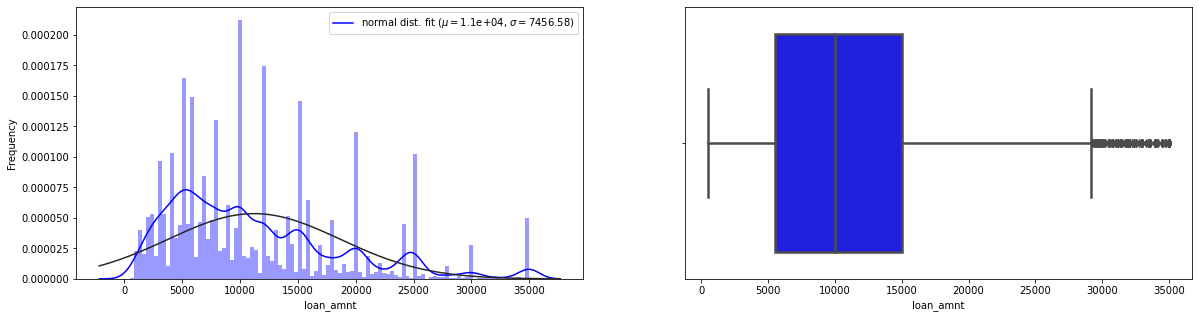

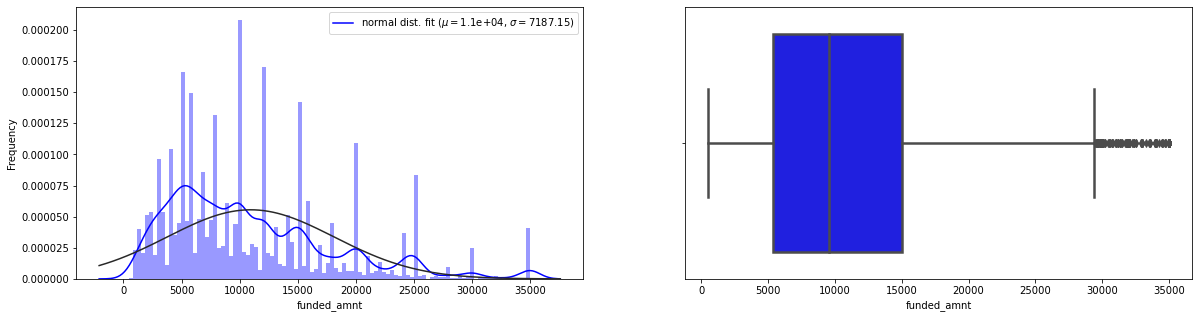

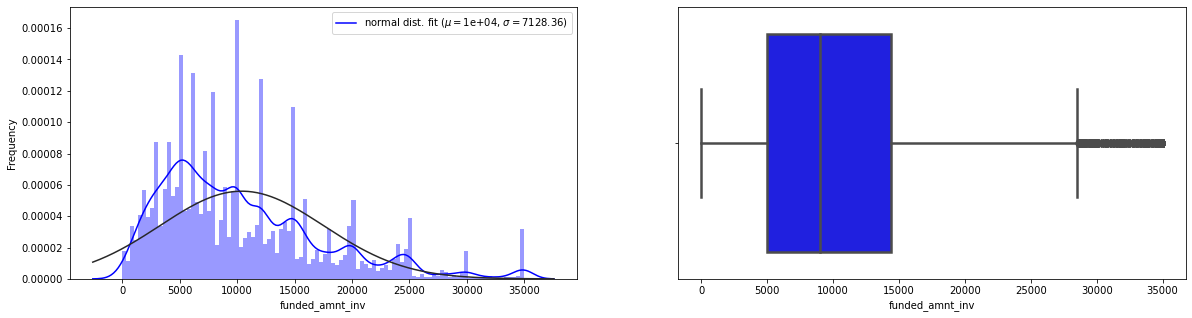

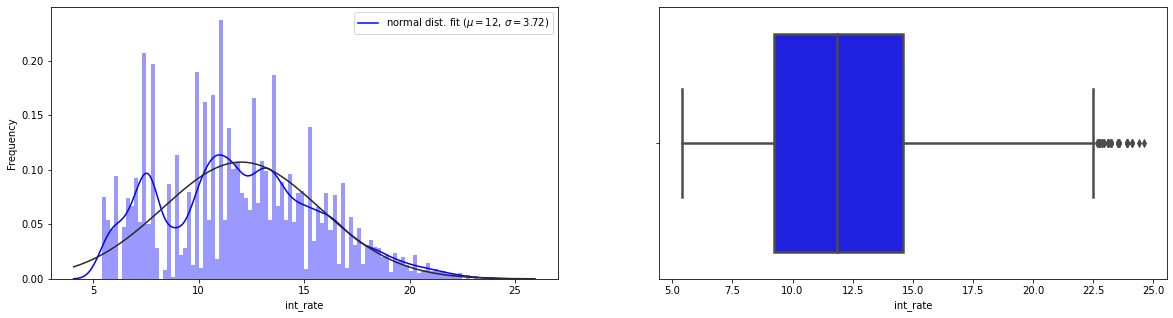

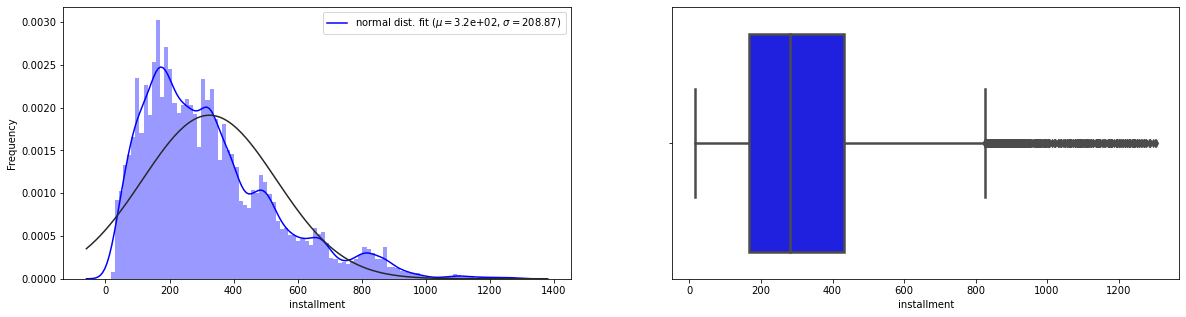

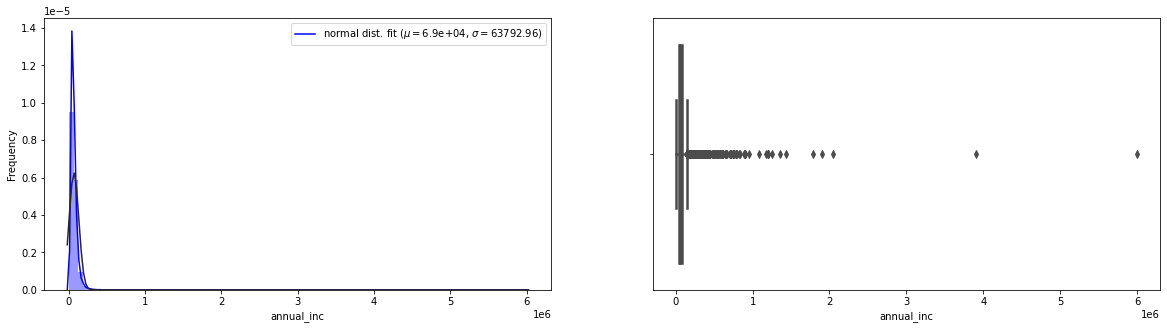

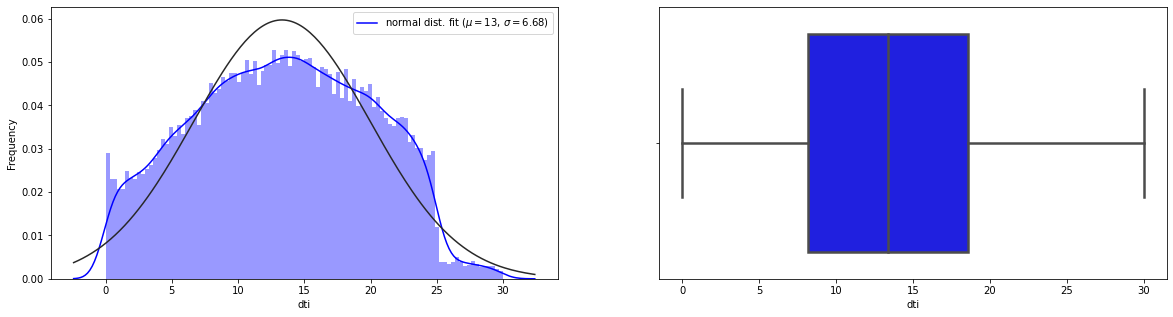

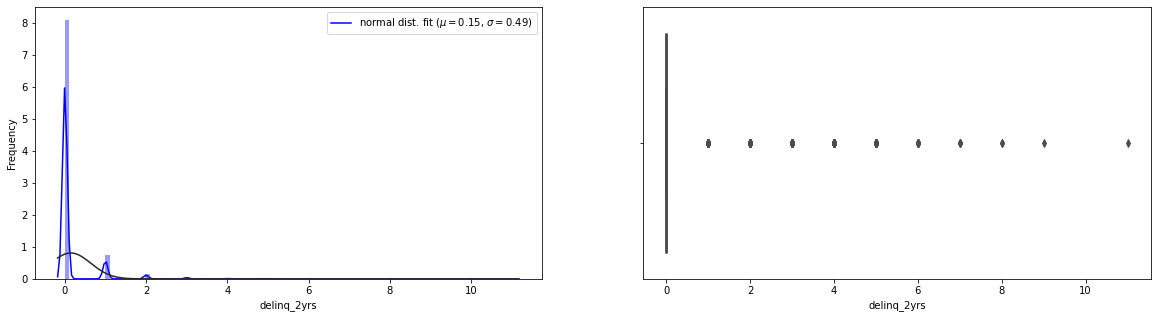

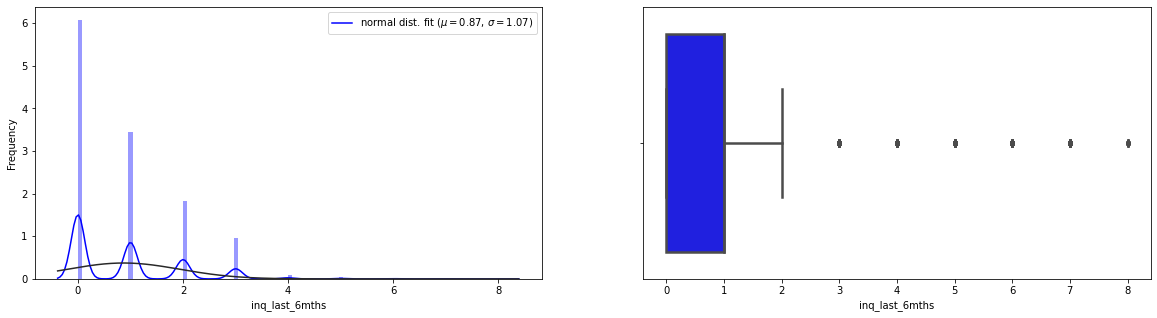

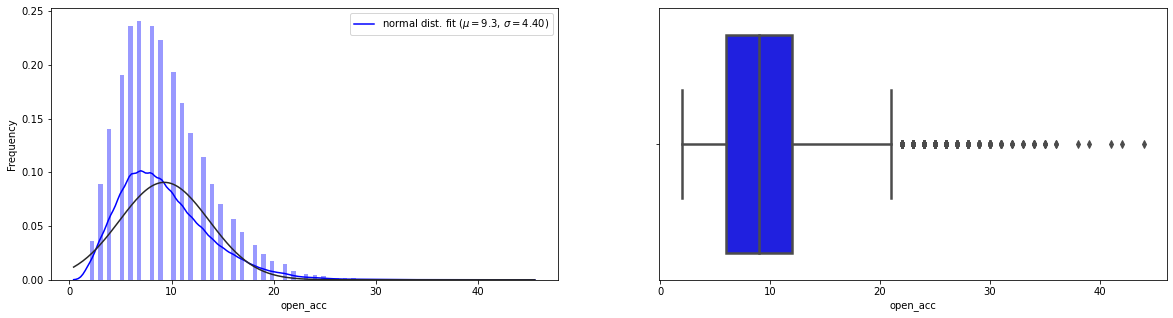

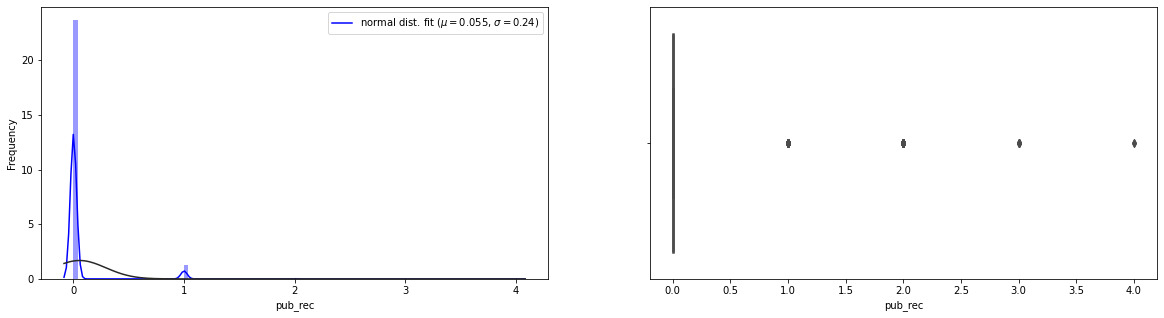

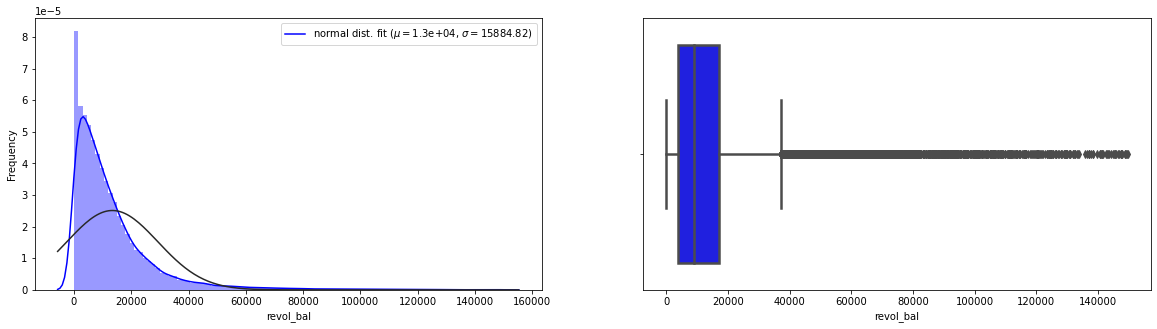

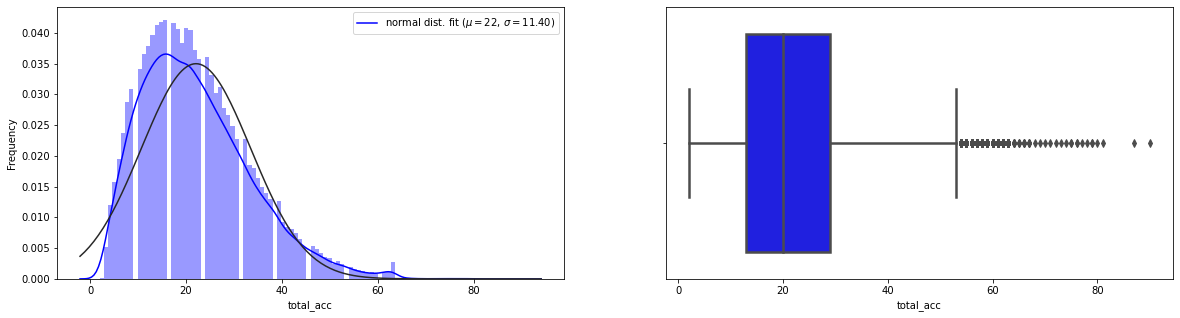

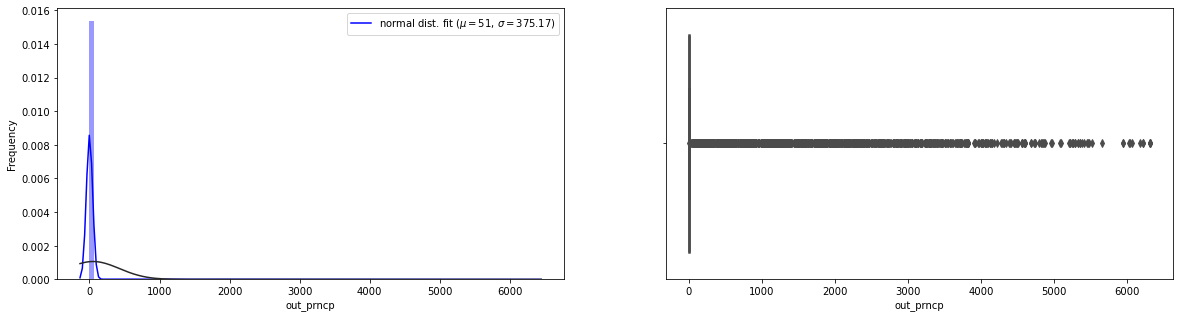

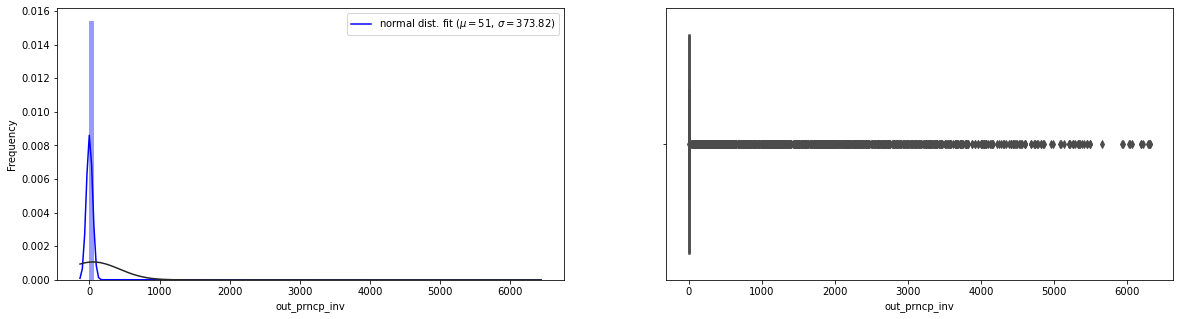

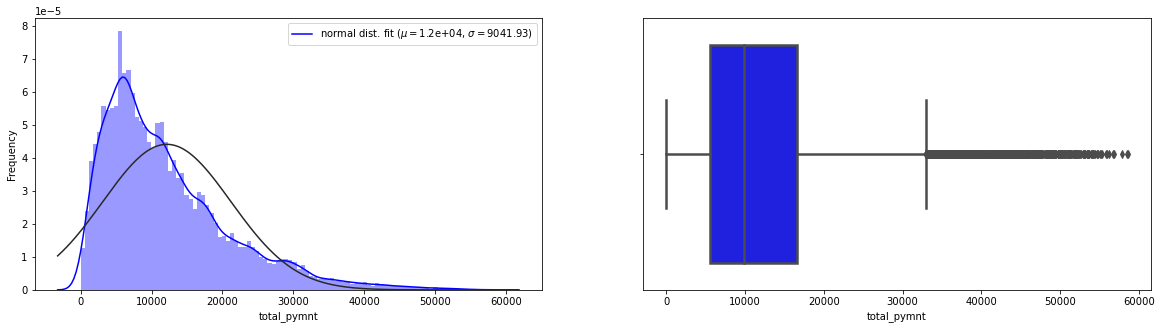

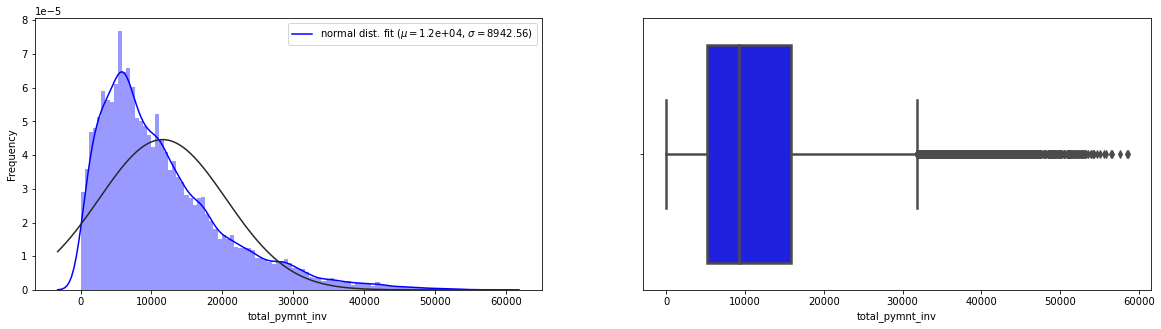

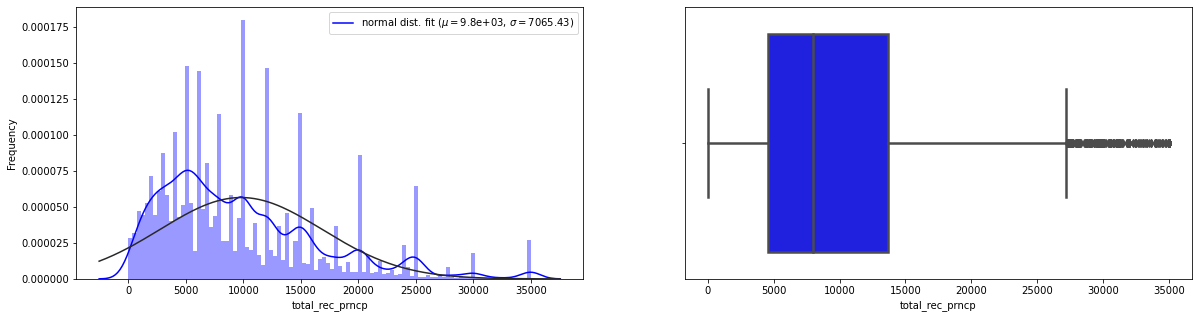

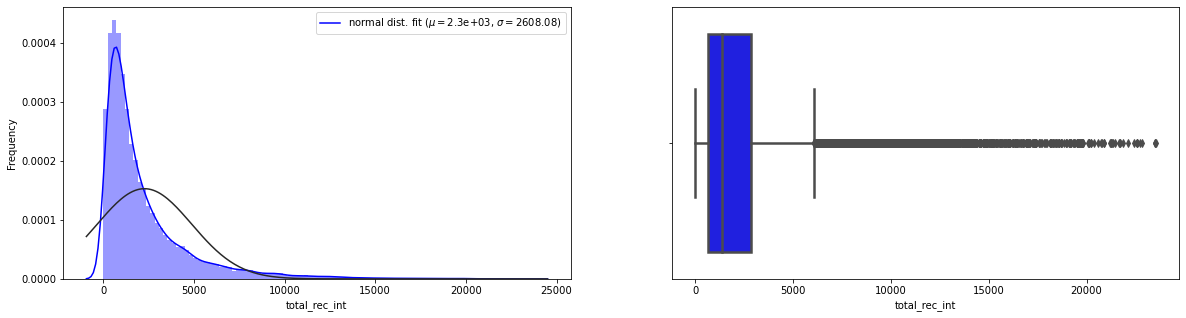

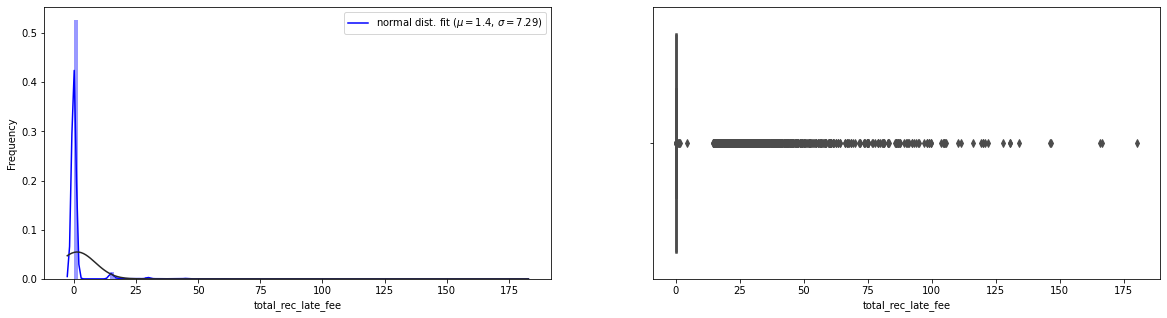

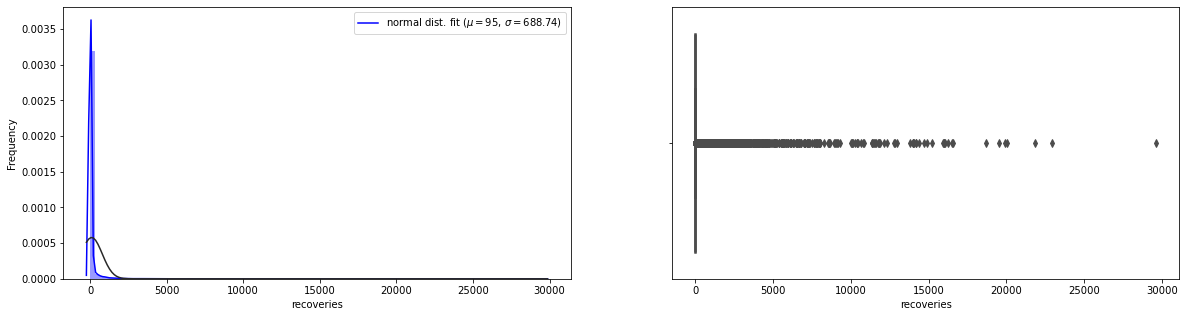

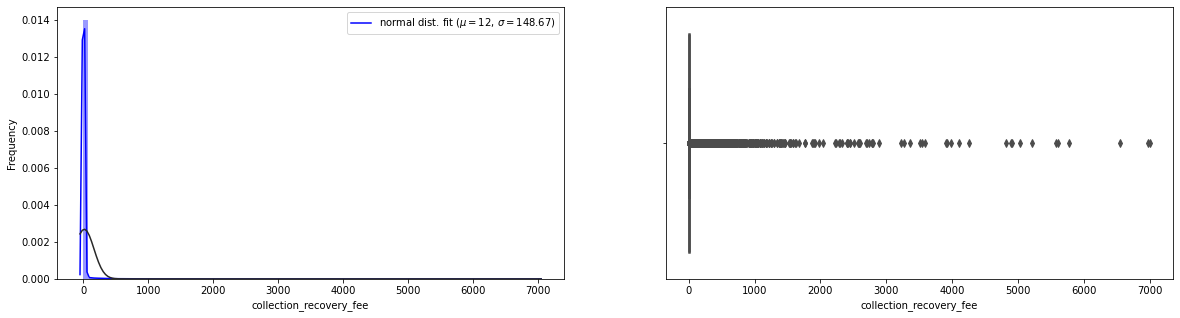

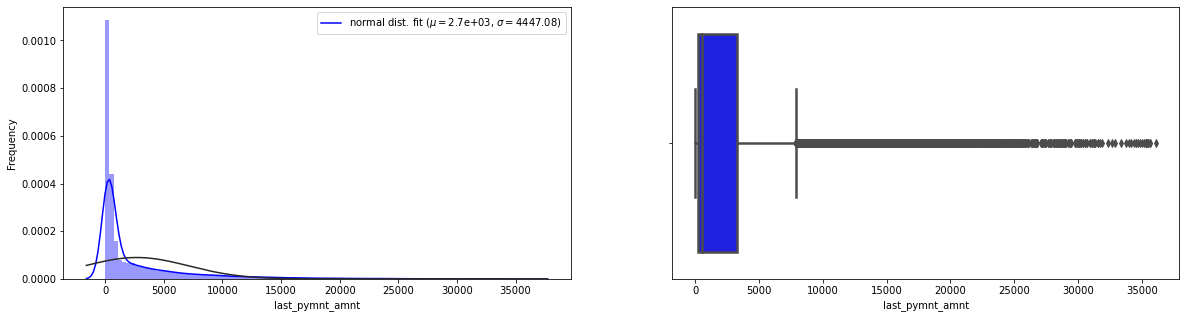

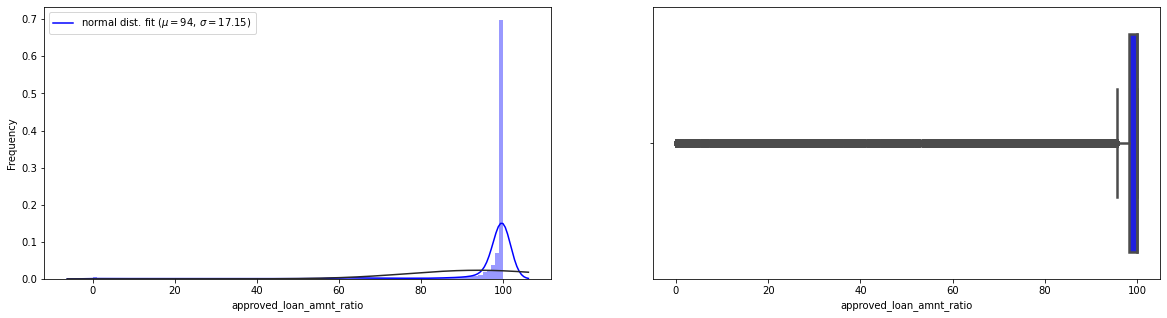

In [14]:
# var = ['loan_amnt','funded_amnt_inv','int_rate','installment','revol_bal','dti','delinq_2yrs']
var = loan.columns[2:]
for i in var:
    plt.figure(figsize=(20,5))
    try:
        plt.subplot(1,2,1)
        sns.distplot(a=loan[i], bins=100,kde=True,color='blue', fit=norm)
        (mu, sigma) = norm.fit(loan[i])
        plt.legend(["normal dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
        plt.ylabel('Frequency')
        plt.subplot(1,2,2)
        sns.boxplot(x=loan[i],color='blue',linewidth=2.5)
       
    except Exception:
        plt.close()
        pass 

plt.show()




## Segmented Univariate Analysis by Year

### We conducted segement univariate analysis by Year, the data is provided from 2007 - 2011 loan issued. Interestingly, highest of the booking  were executed in recent years. Most of the loan which which were issued 2011 were at on the higher percentile .i.e. higher compare to previous years.Overall the data split by year didnt showed much variance except in 2007. Hence, we decided to do further EDA.




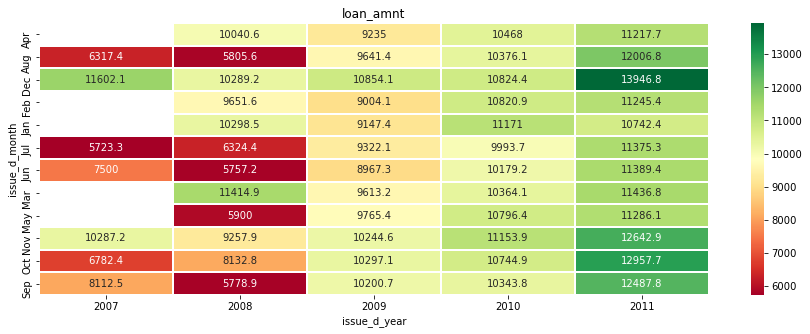

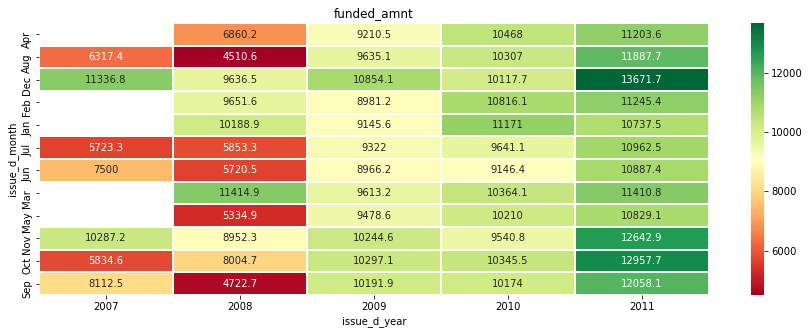

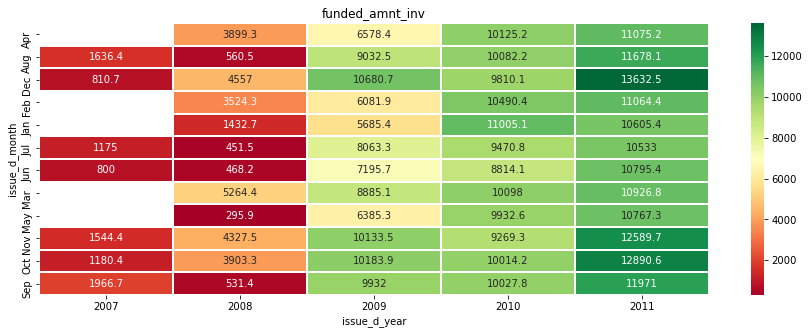

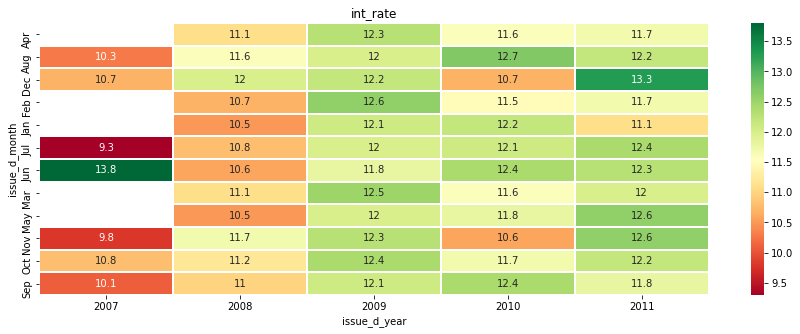

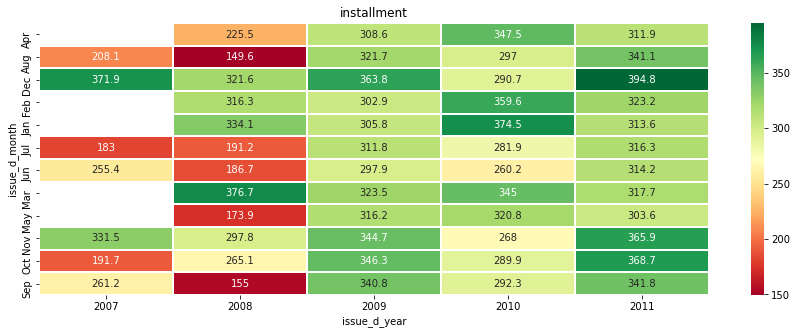

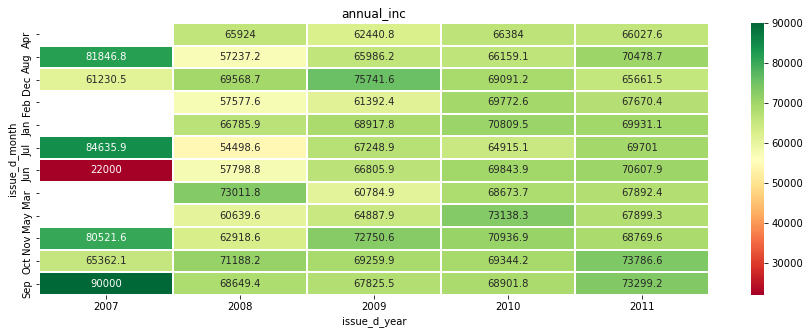

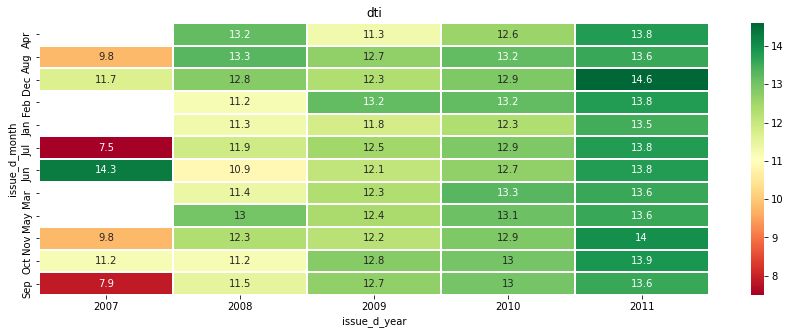

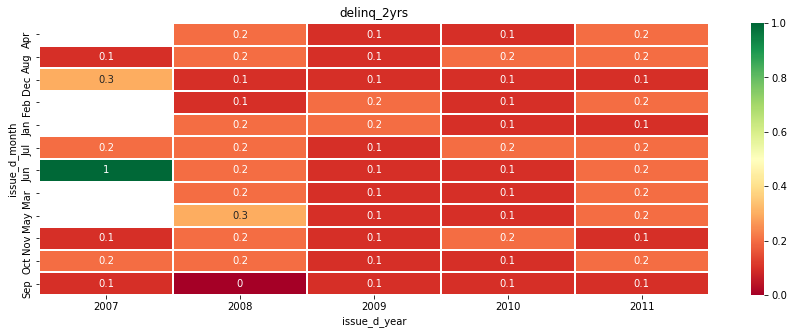

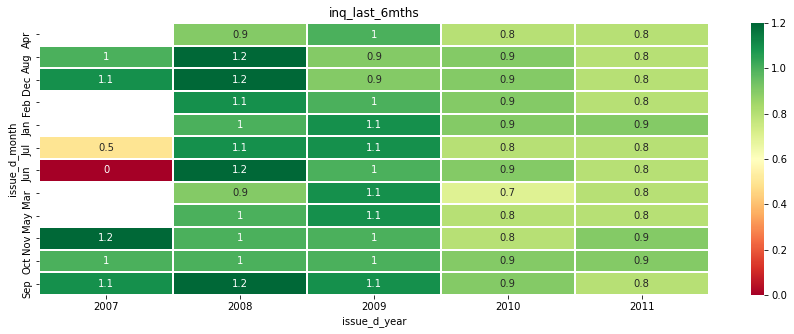

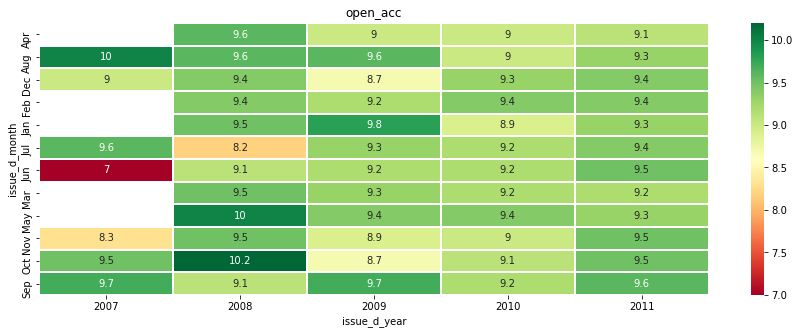

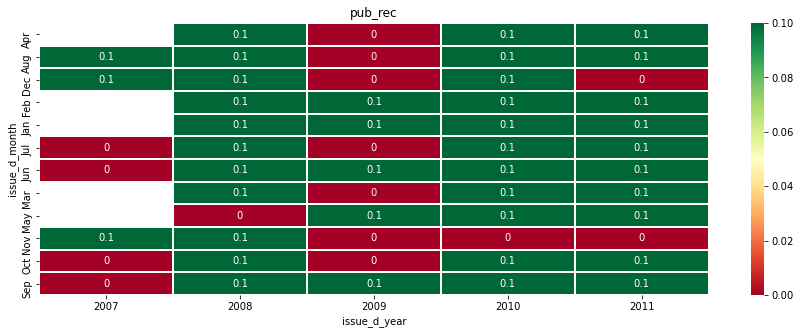

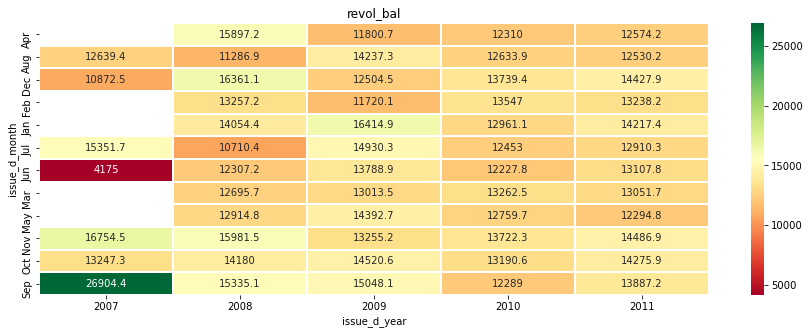

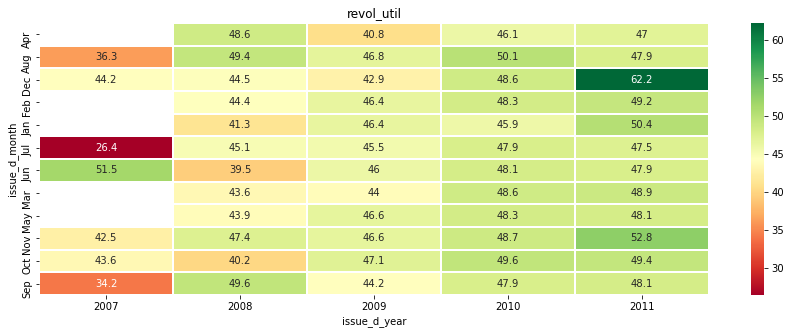

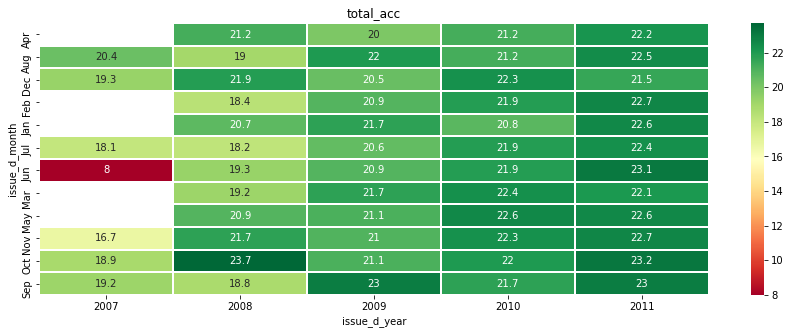

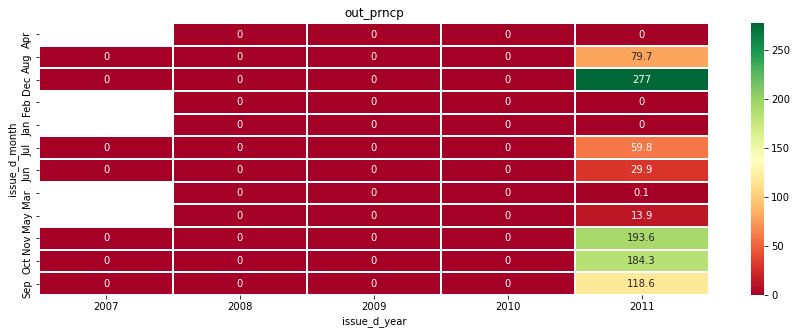

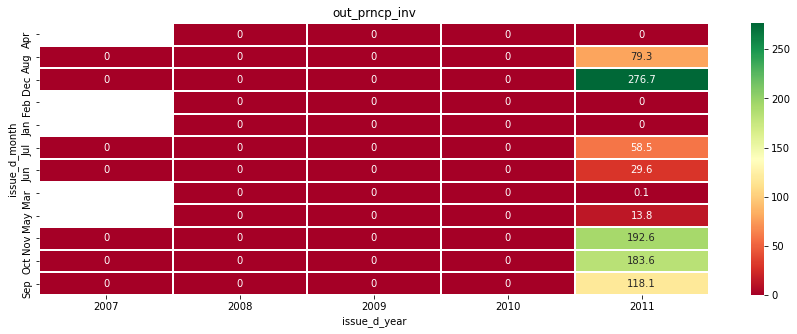

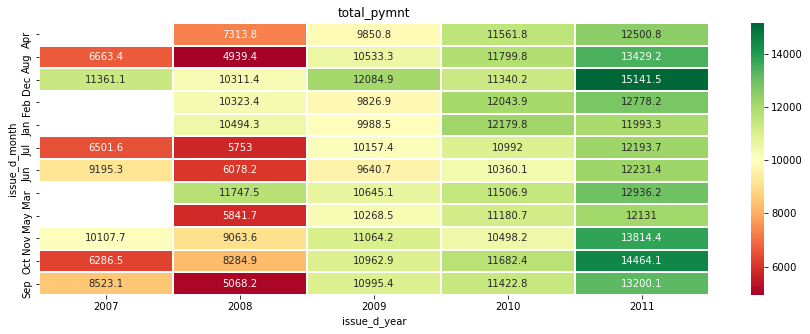

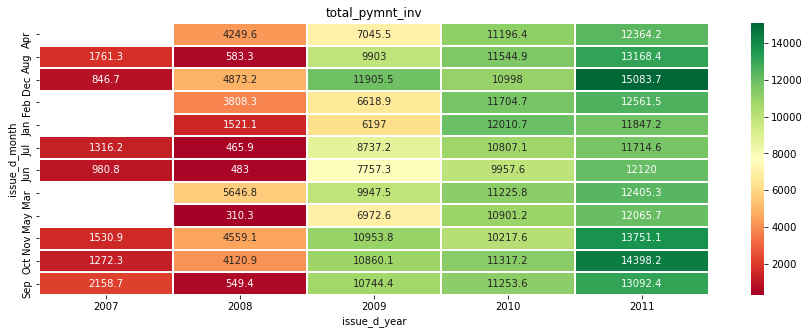

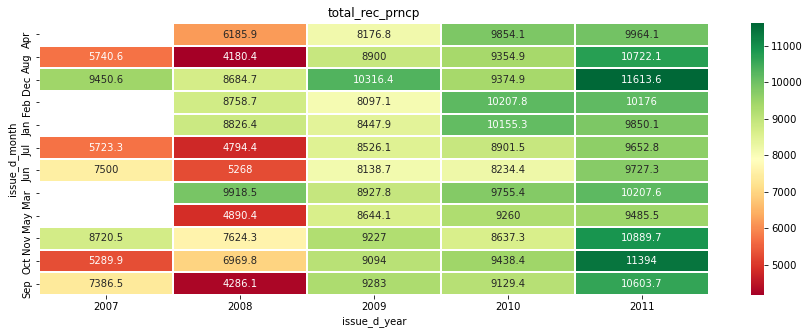

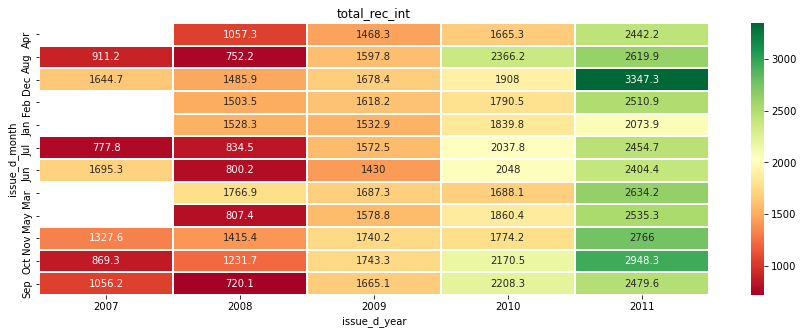

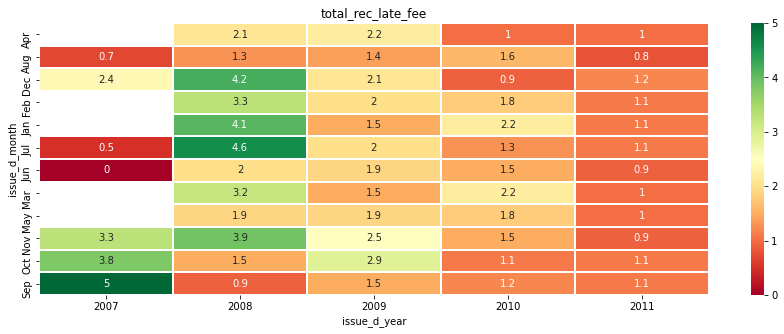

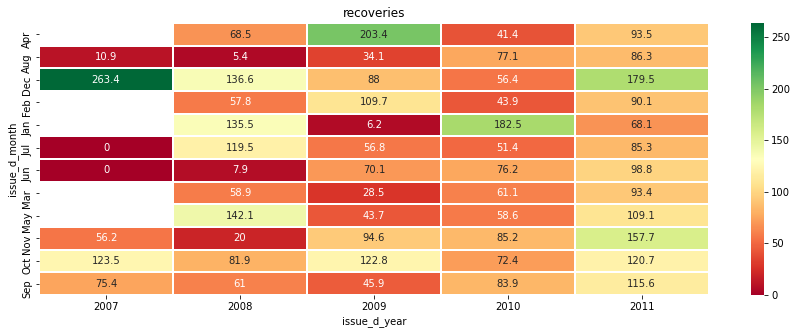

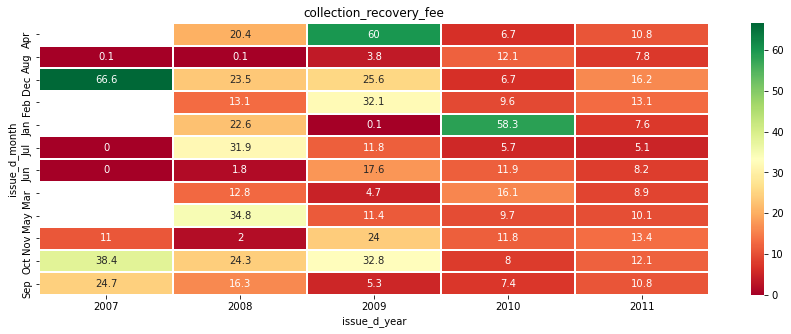

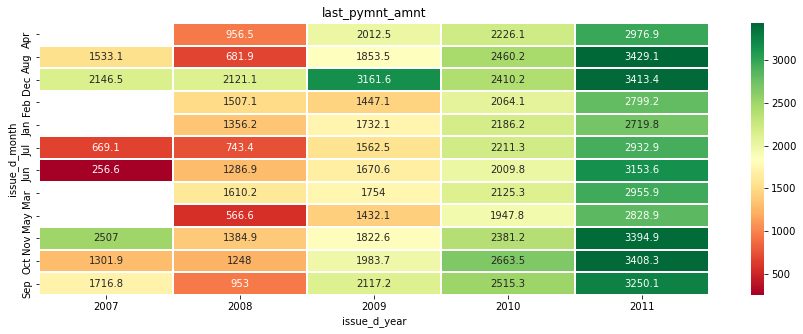

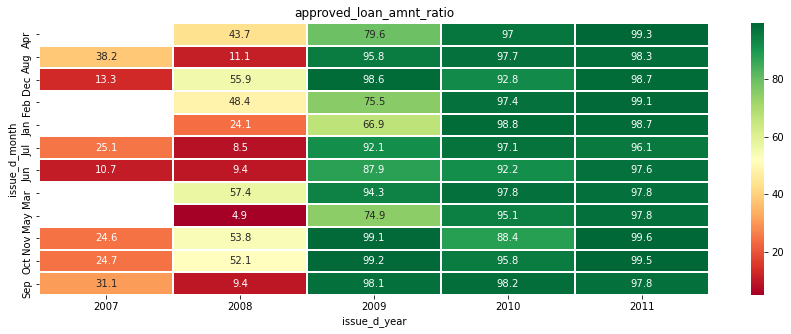

In [15]:
#var = ['loan_amnt']
var = loan.columns[2:]
for i in var:
    plt.figure(figsize=(15,5))
    try:
        loanheat = loan.pivot_table(values=i,index='issue_d_month',columns='issue_d_year').round(1)
        #display(loanheat)
        sns.heatmap(loanheat,cmap='RdYlGn',linecolor='white',linewidths=1,annot=True,fmt='g')
        plt.title(str(i))
        plt.show()
    except Exception:
        plt.close()
        pass 



### Bivariate analysis 

### We decided to further EDA by using Bivariate Approach.We noticed the purpose, sub_grade and states address (discreet variable) agains the continues variables.We noticed that :-

Large exposure in loan largely in SME, Debt Consolidation, House Improvement, Credit Card payoff and follow by Energy related purpose.
In addition, large credit card balance under revolving and large recoveries in the SME & Energy. 



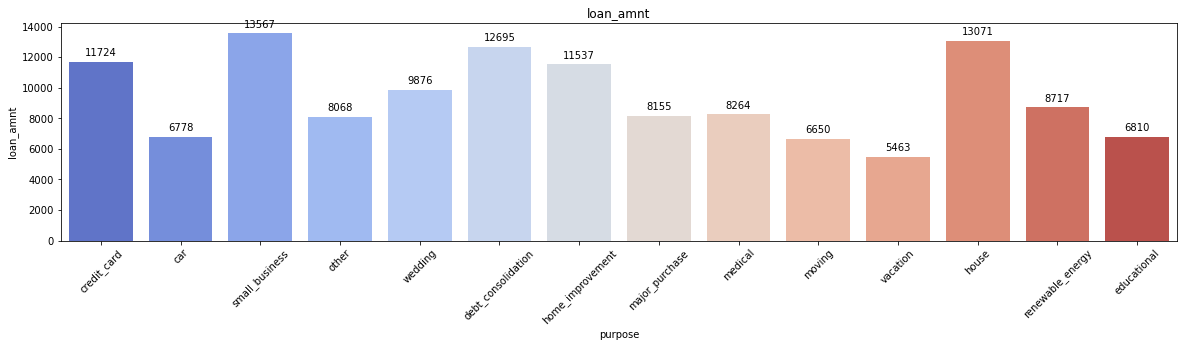

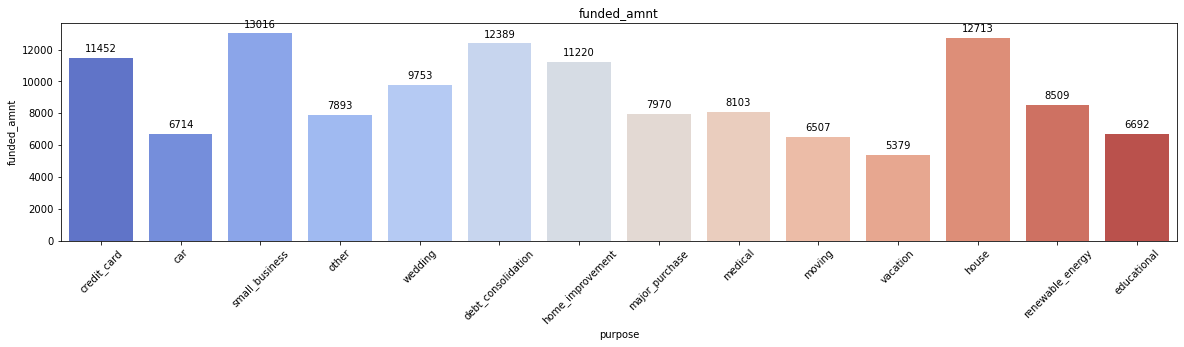

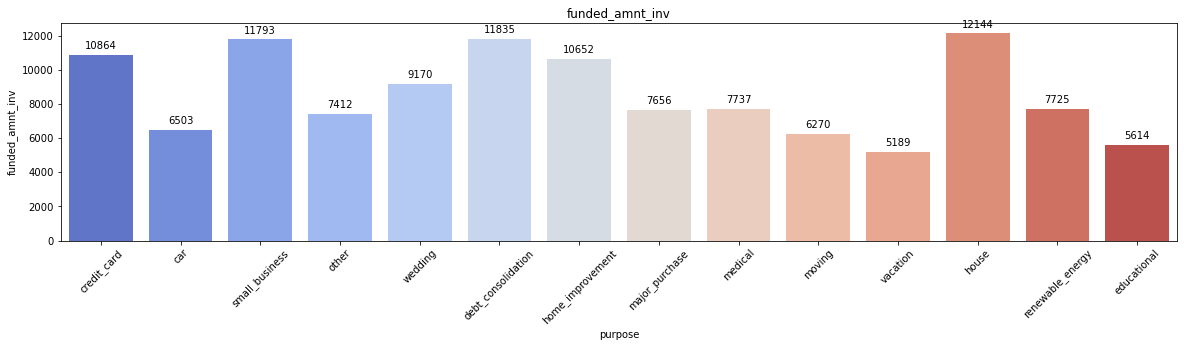

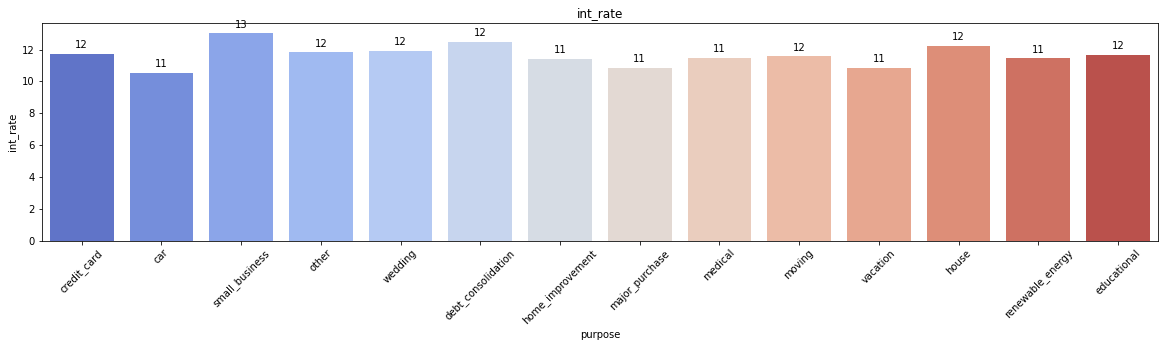

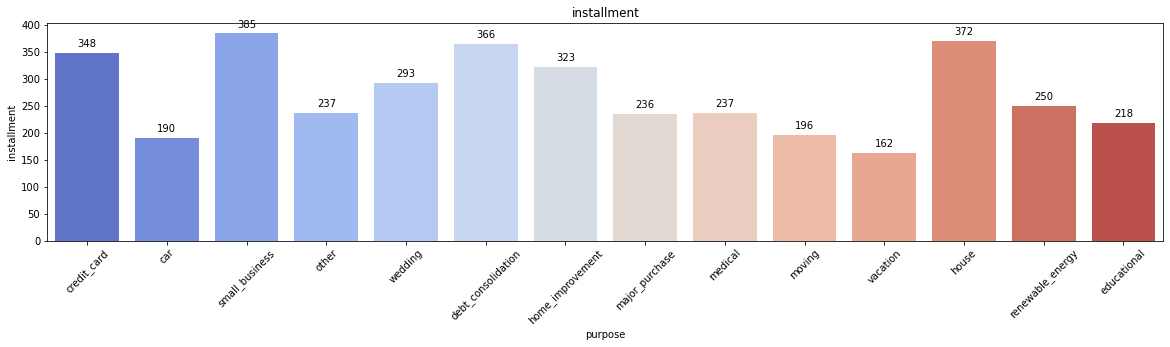

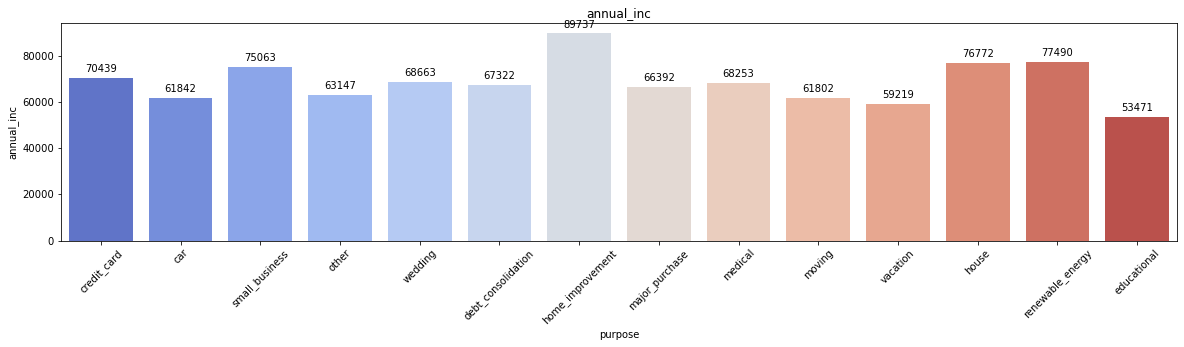

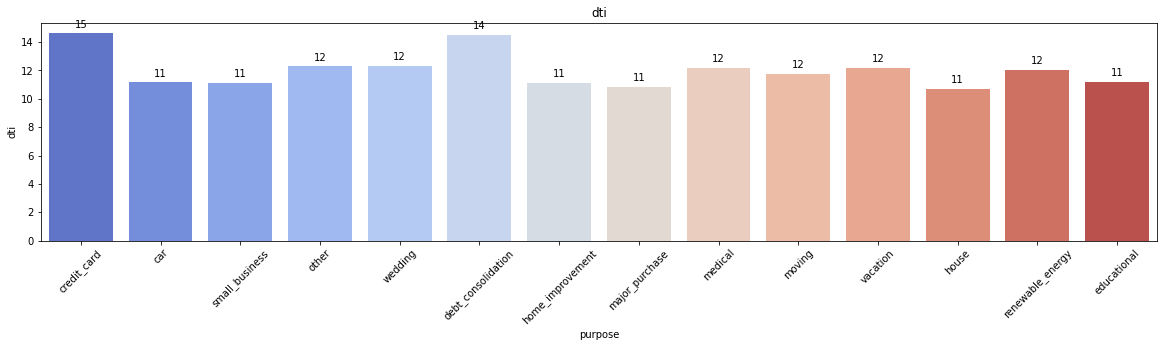

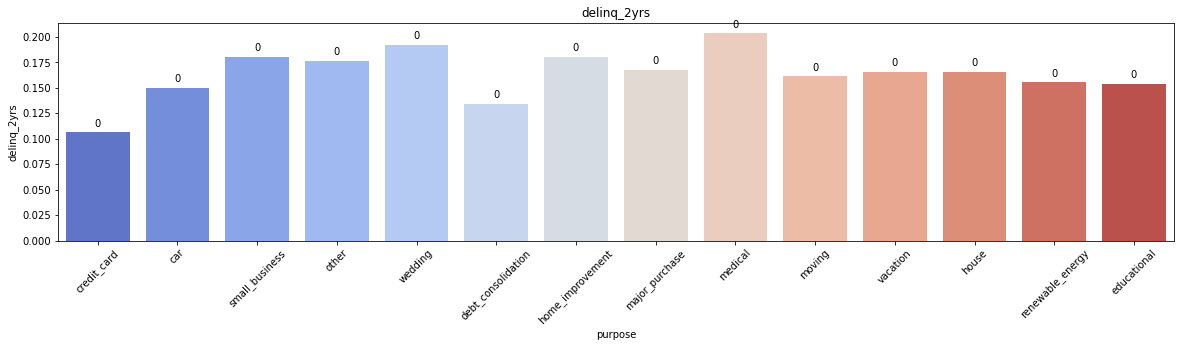

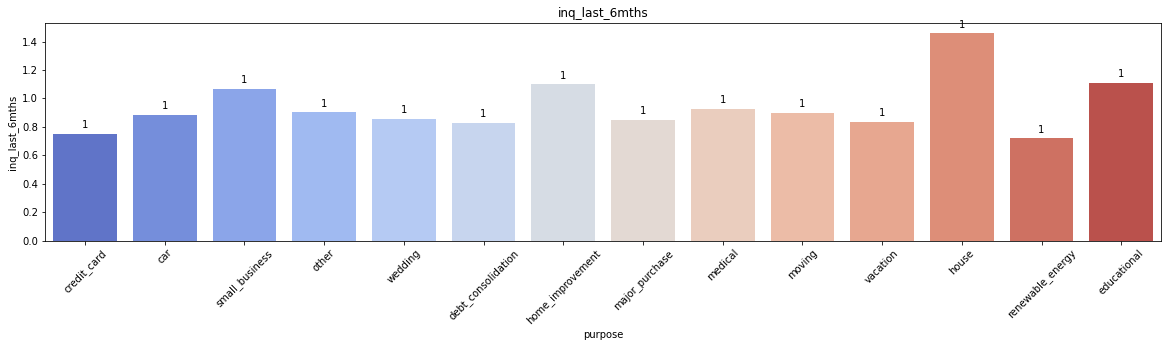

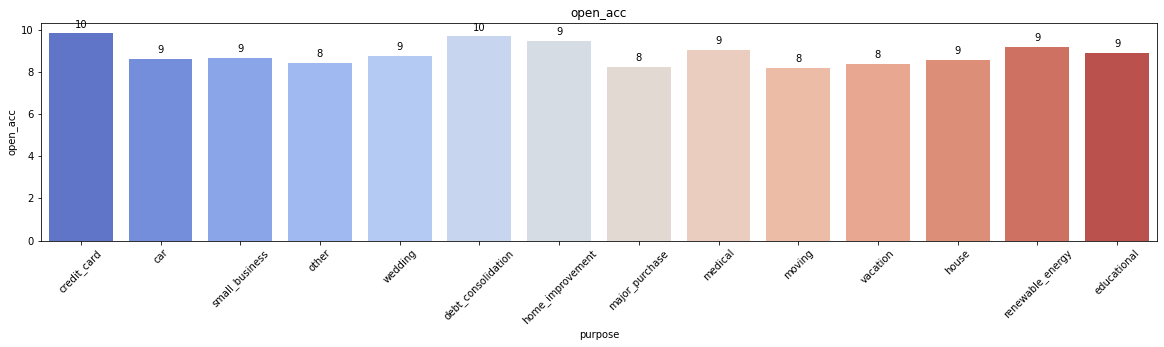

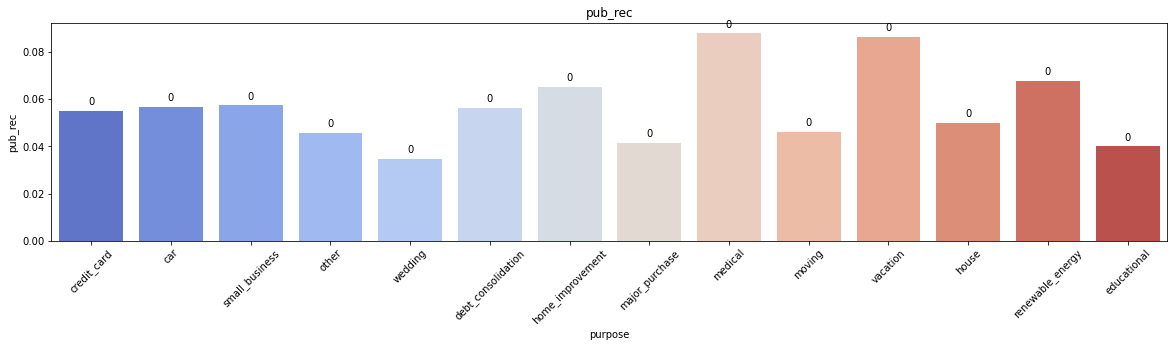

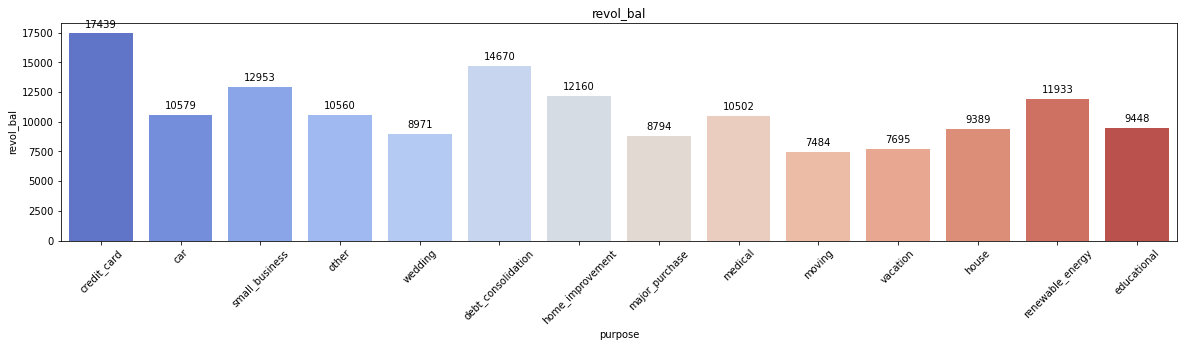

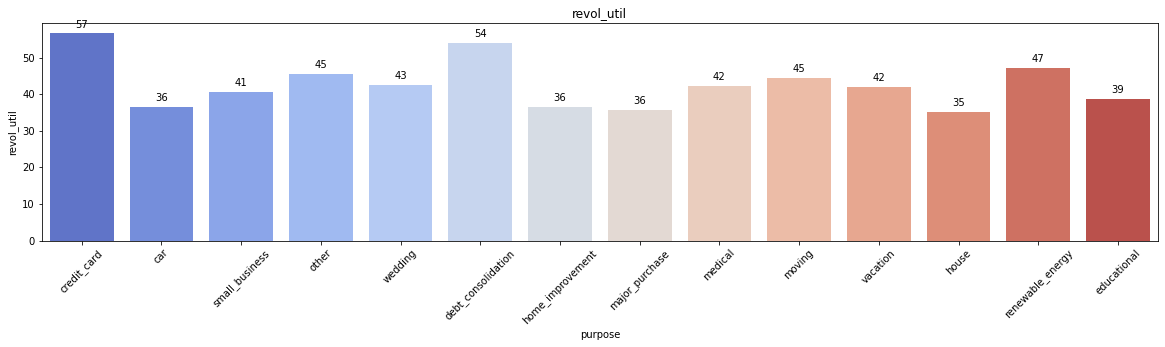

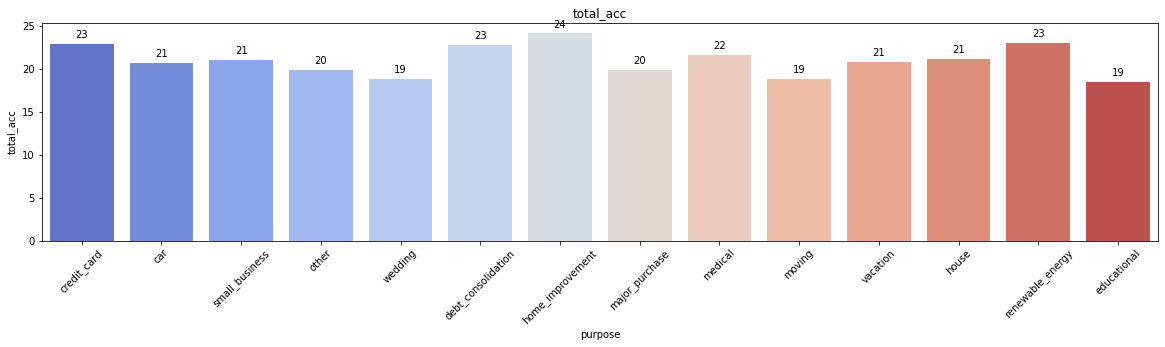

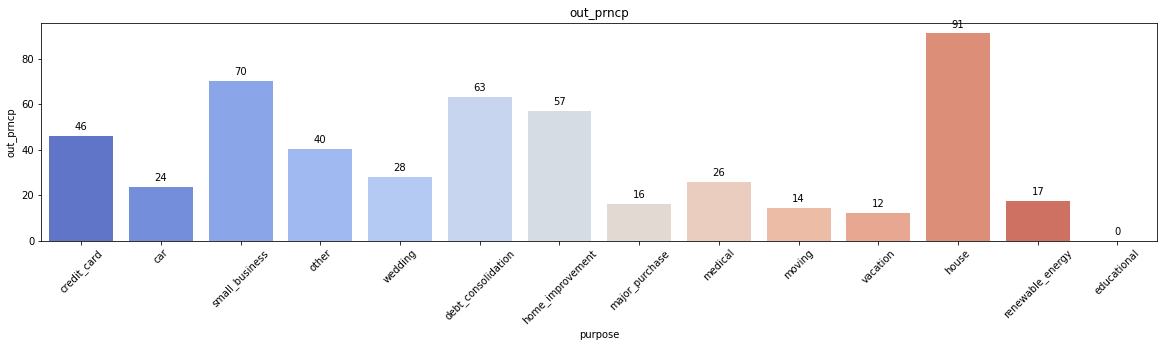

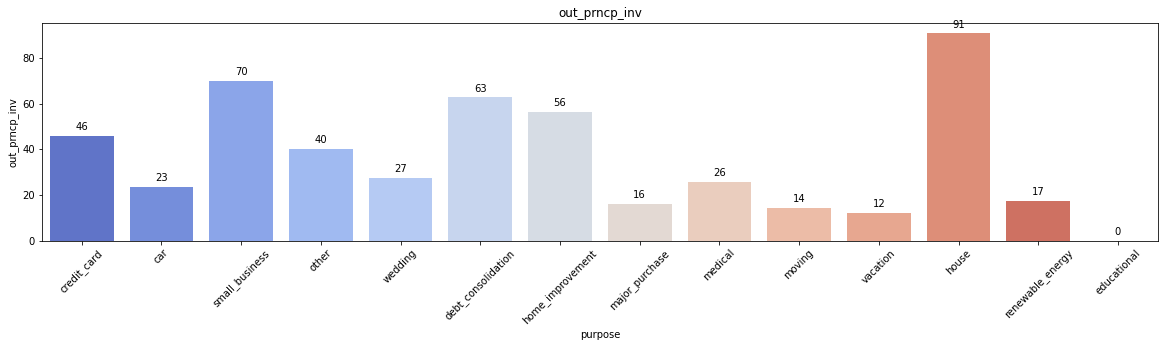

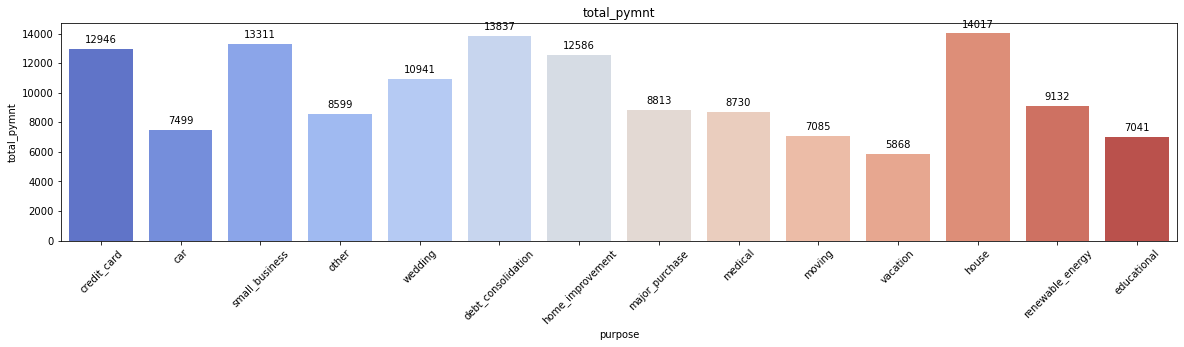

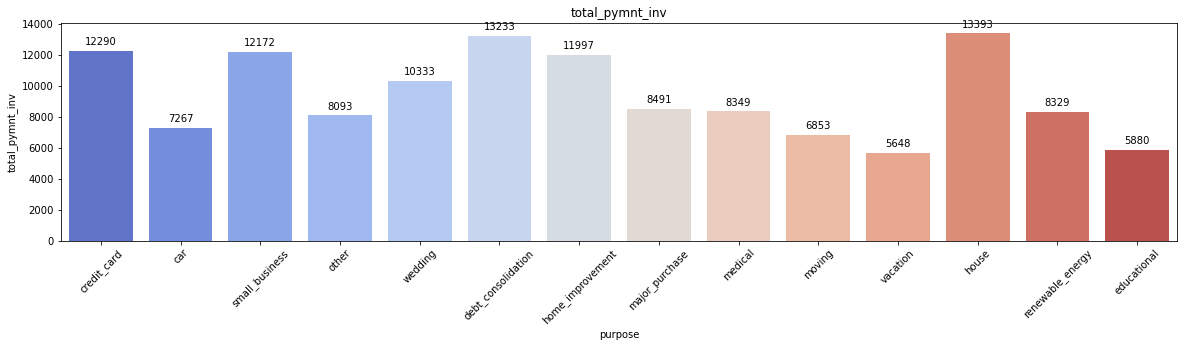

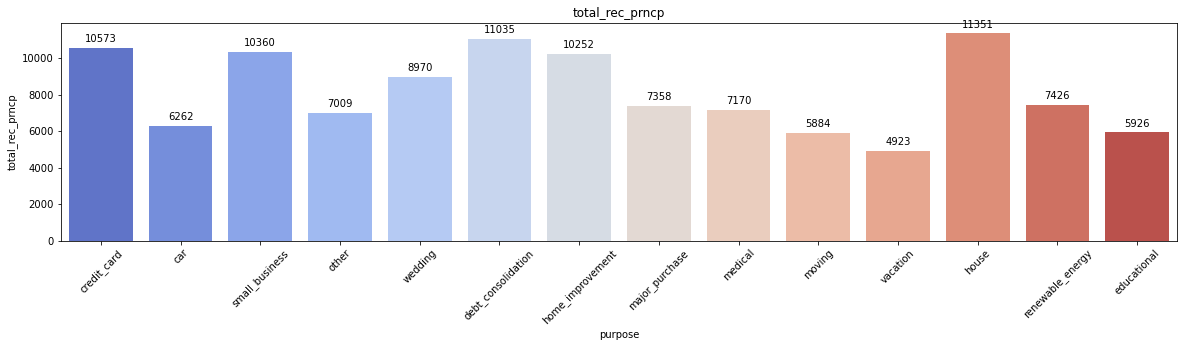

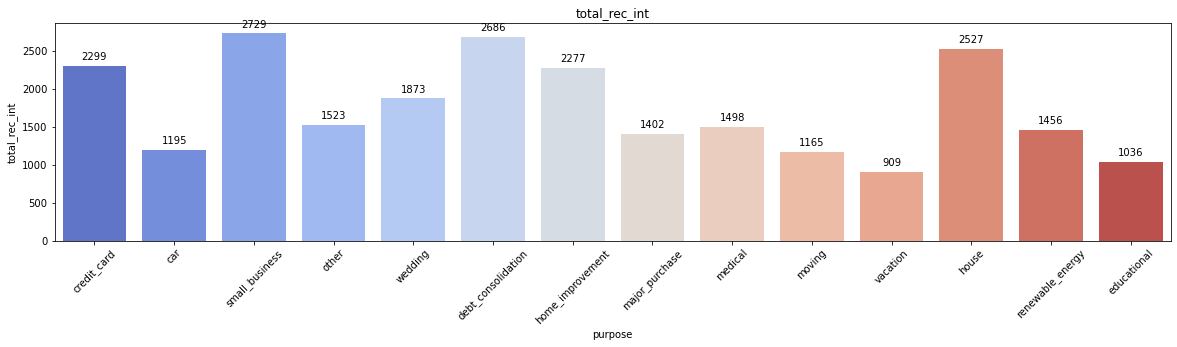

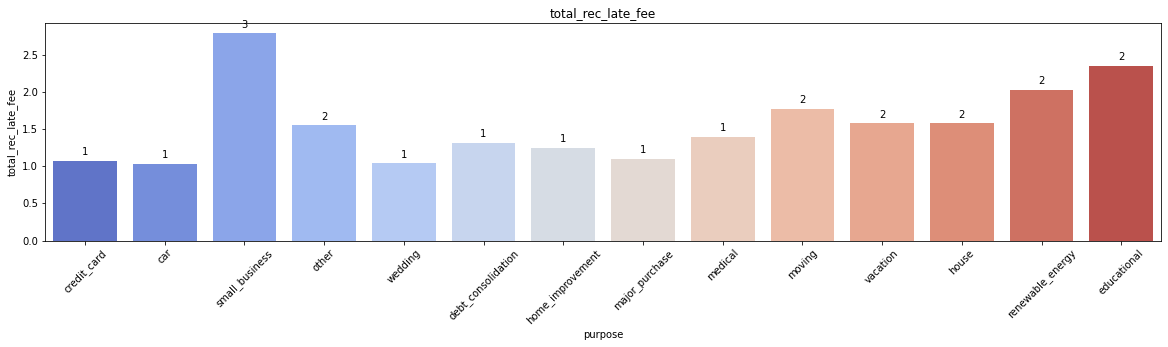

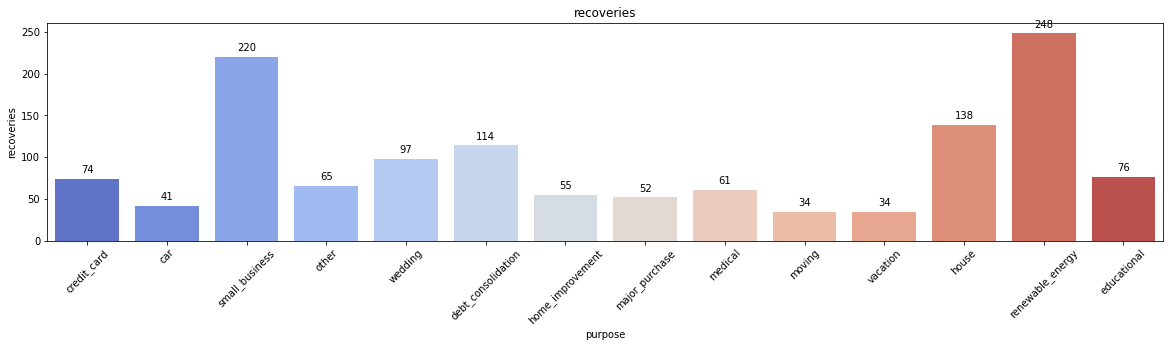

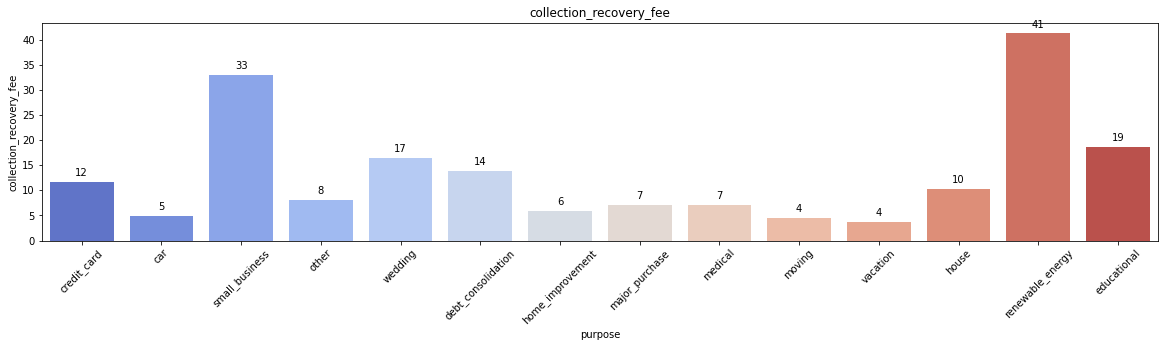

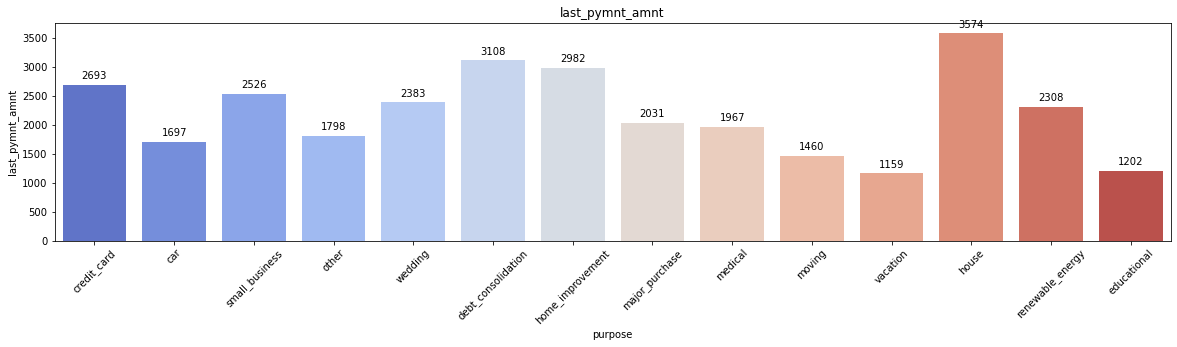

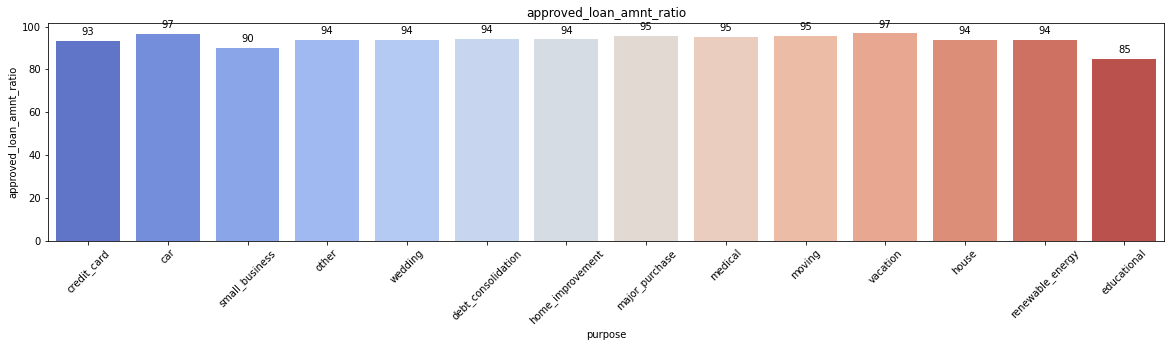

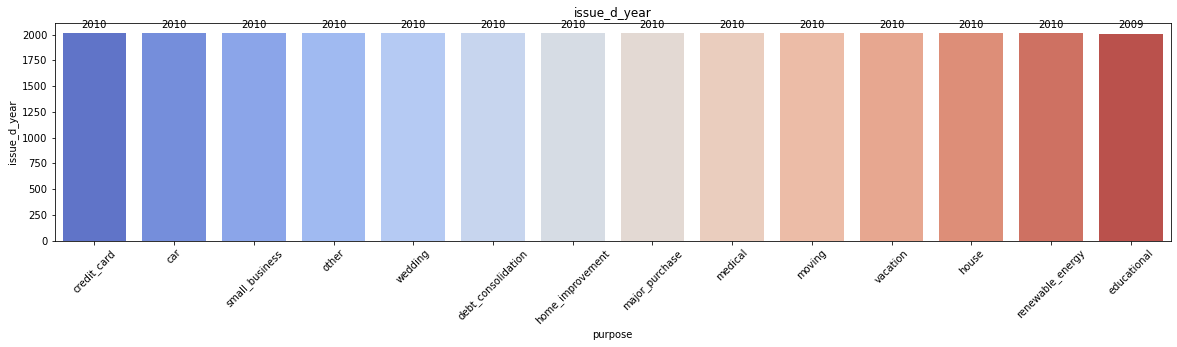

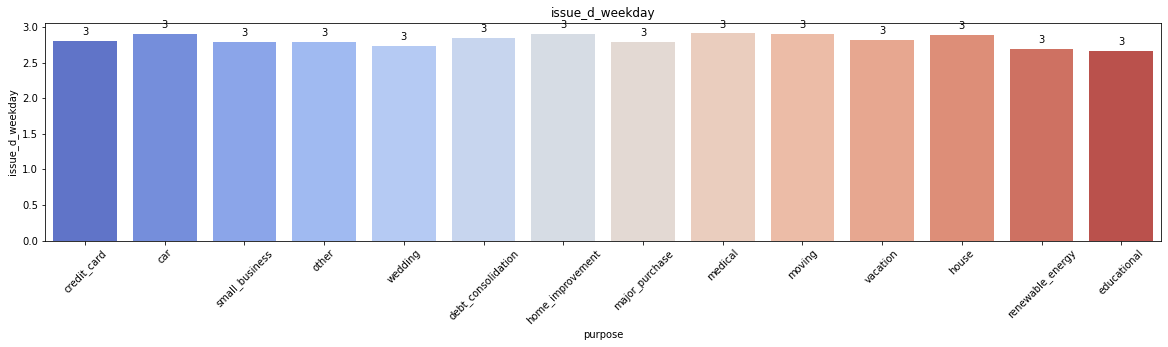

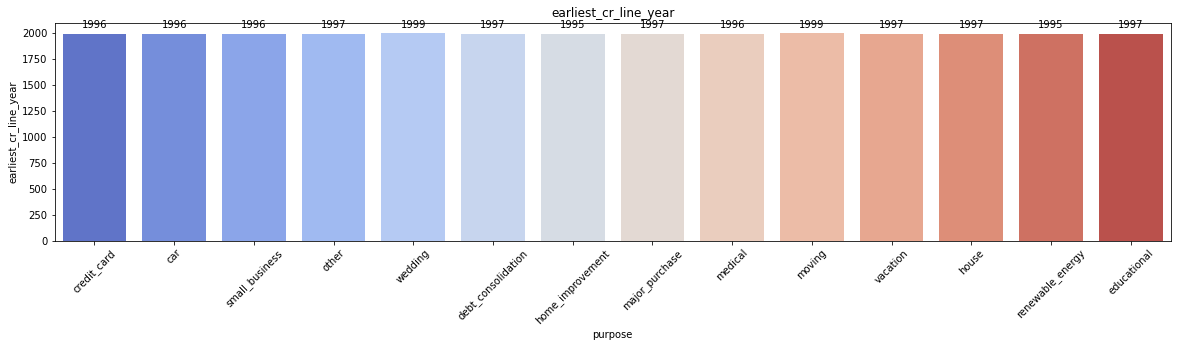

In [16]:
var = loan.columns[2:]
for i in var:
    plt.figure(figsize=(20,4))
    try:
        splot = sns.barplot(x='purpose', y=i,  data=loan,  ci=None,  capsize=.2, palette='coolwarm')
        plt.title(str(i))
        
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')
        plt.xticks(rotation=45)
       
    except Exception:
        plt.close()
        pass 

plt.show()
        

### Bivariate analysis

### We perform similar analysis used sub_grade. Interestingly, we noticed the lower grade customer tend to get / apply for higher loans. There deliquency and recovery metrics remain on higher side, hence suggesting such lower grade customers should not be entertained or provided with loans.

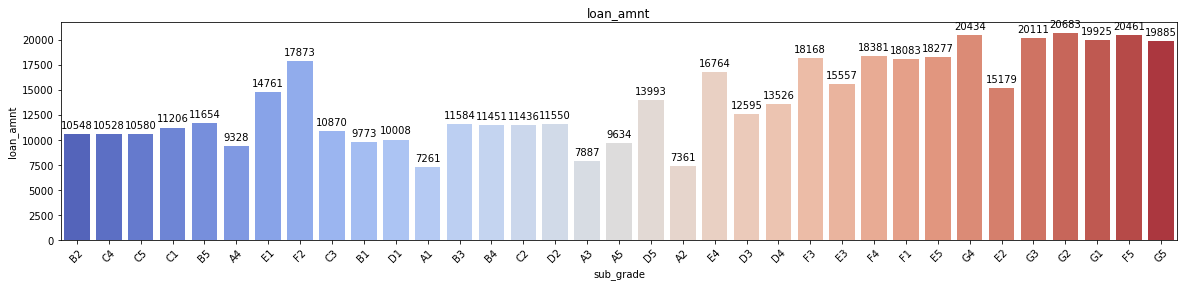

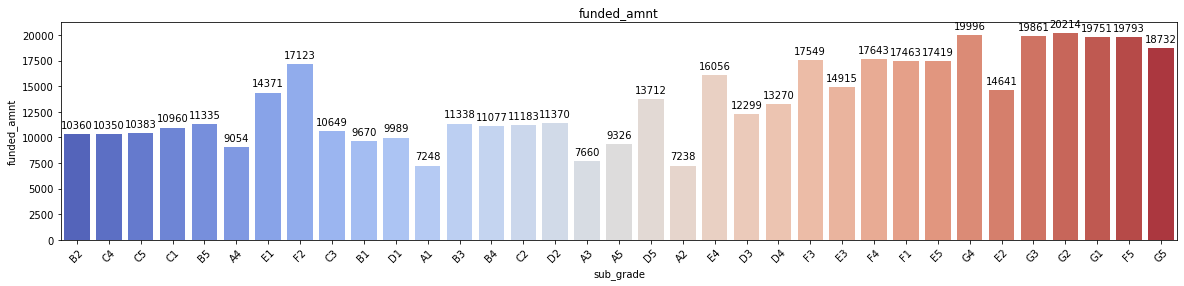

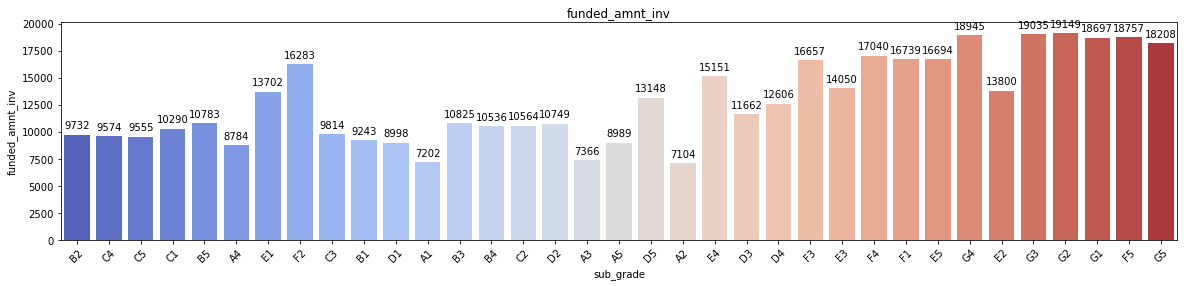

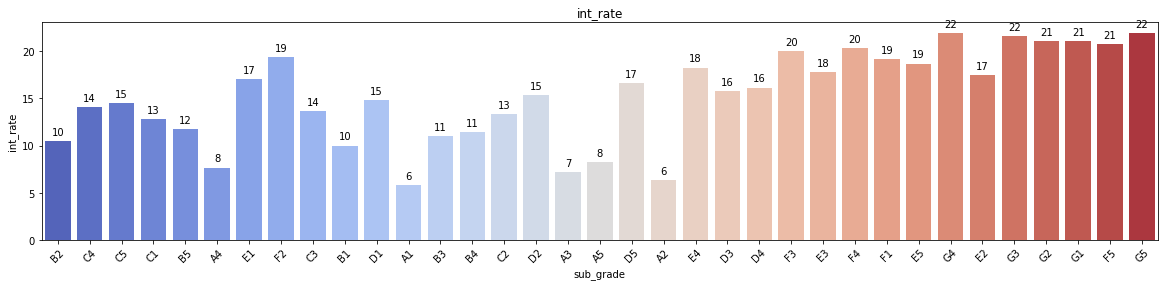

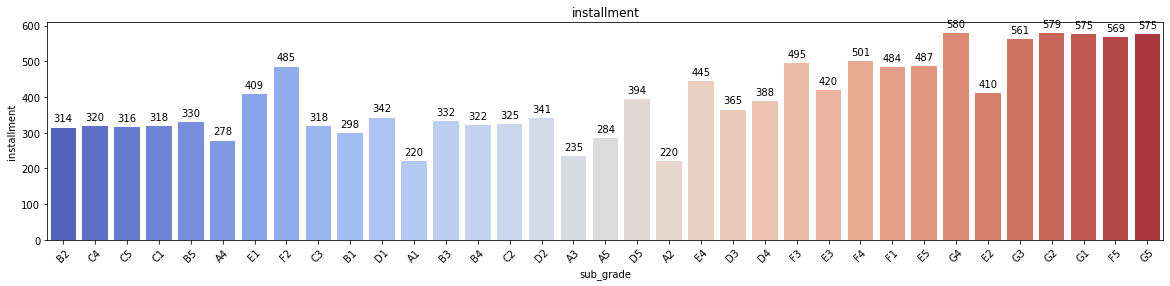

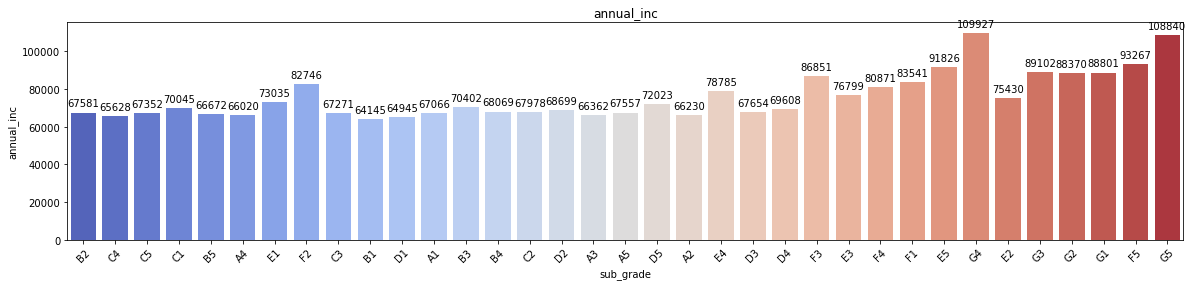

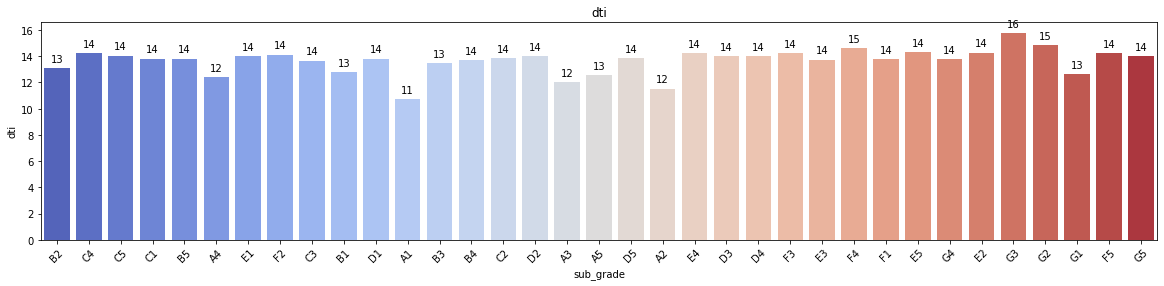

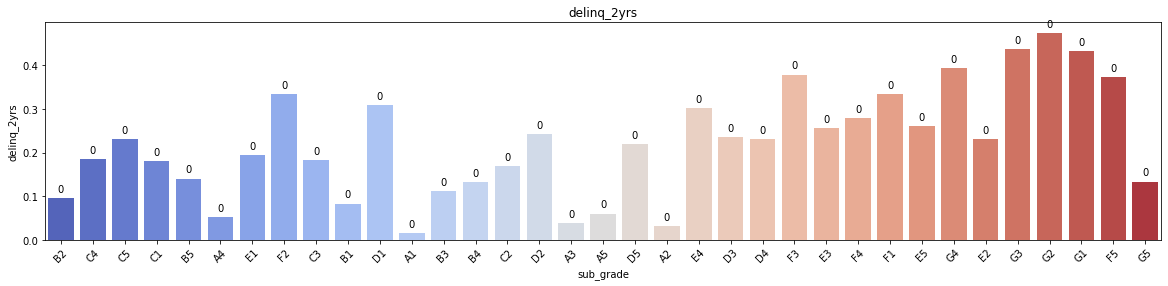

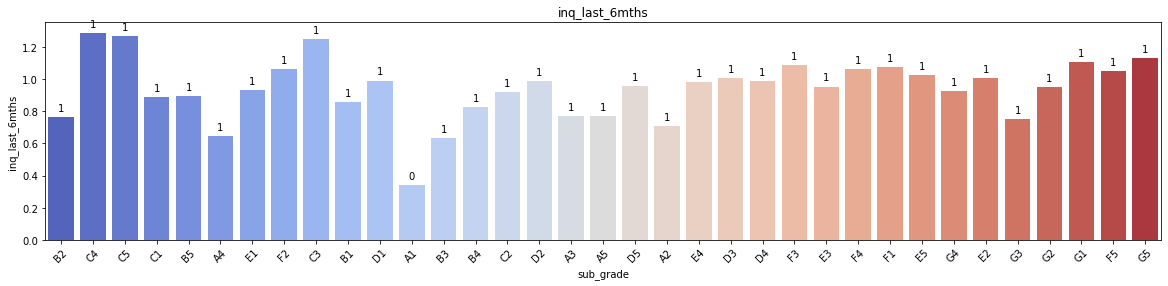

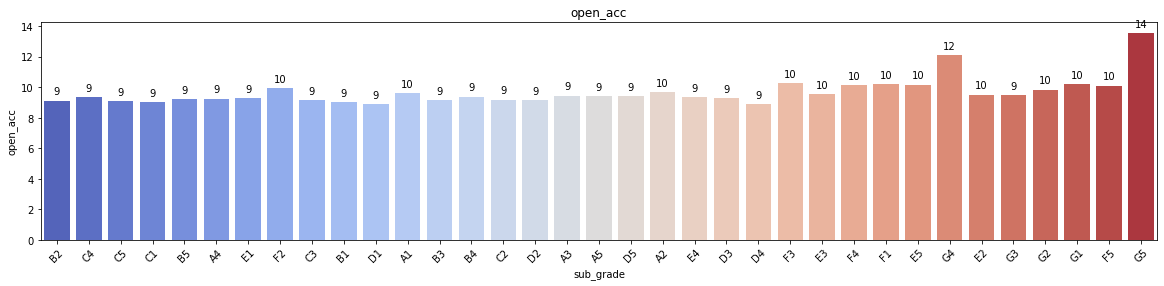

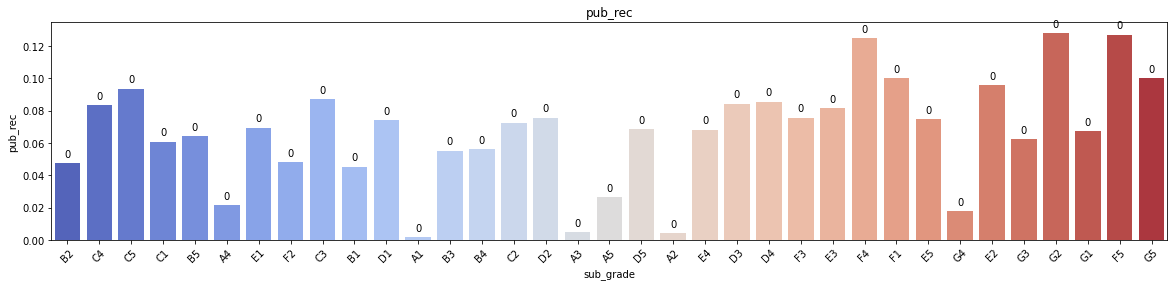

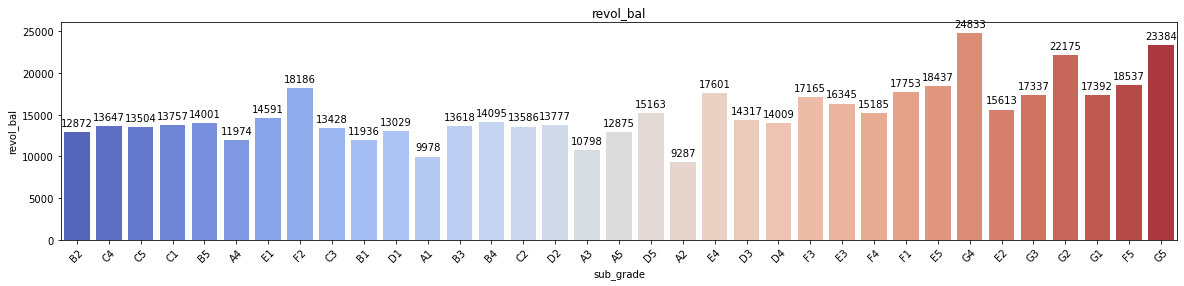

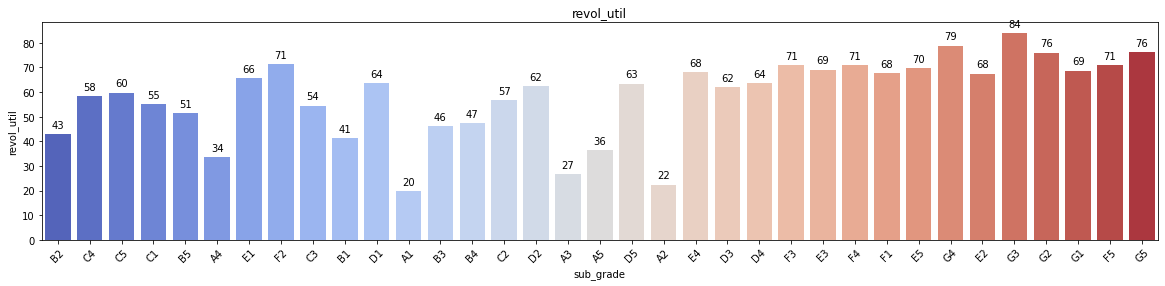

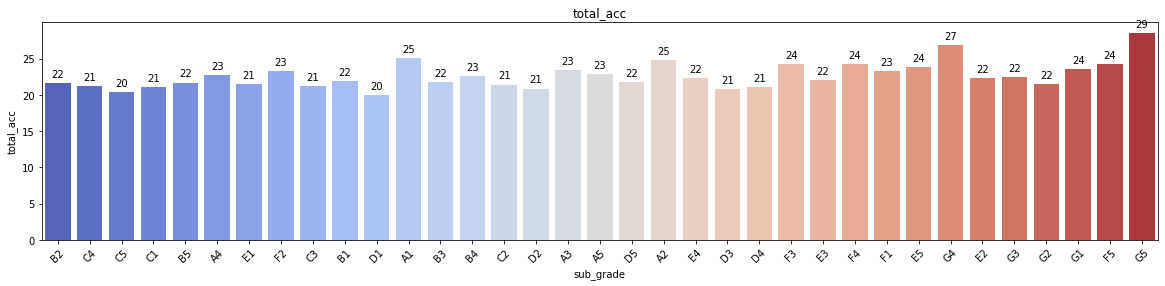

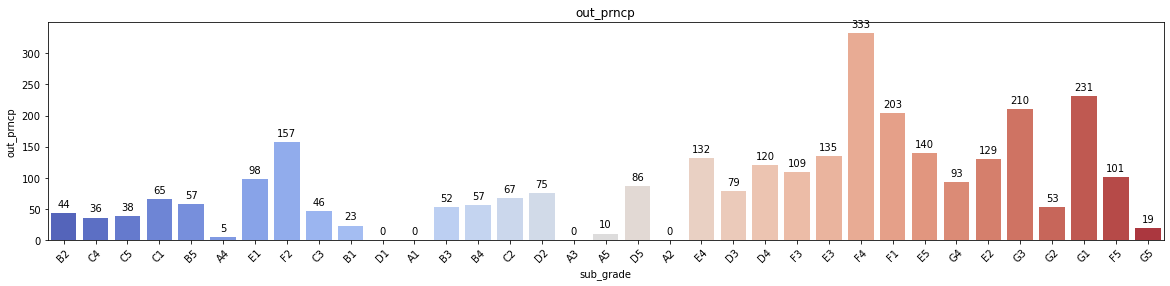

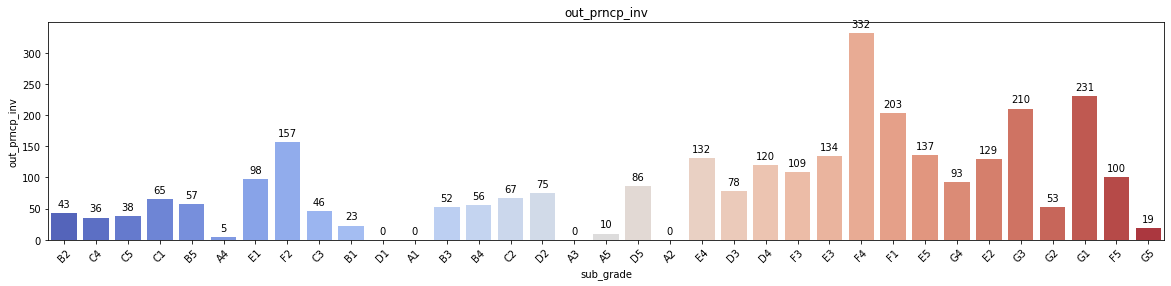

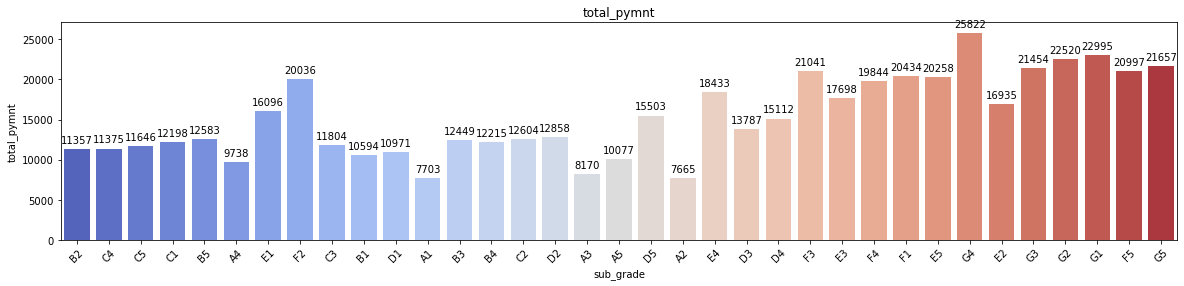

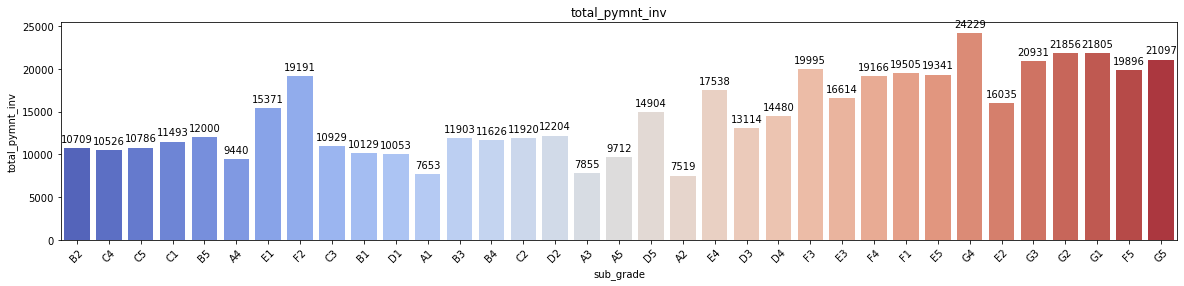

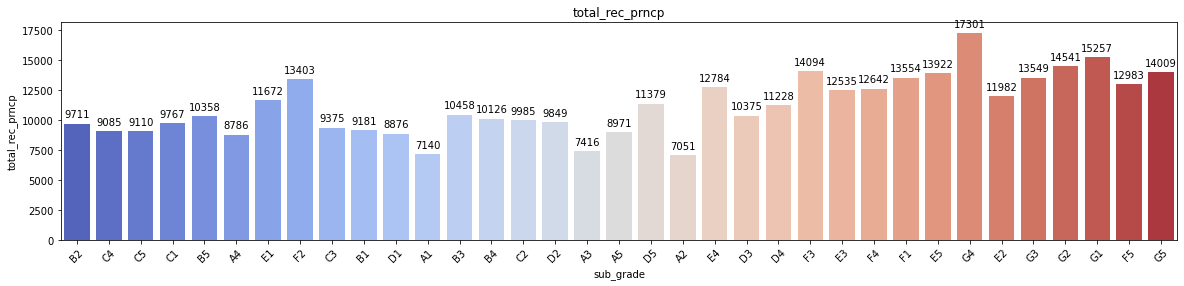

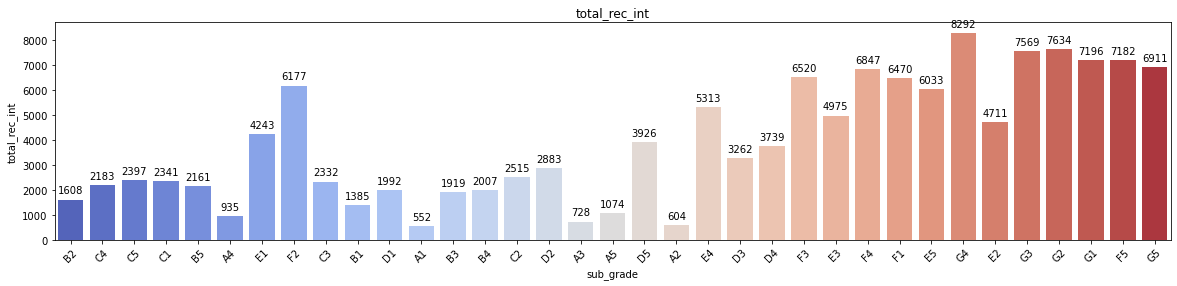

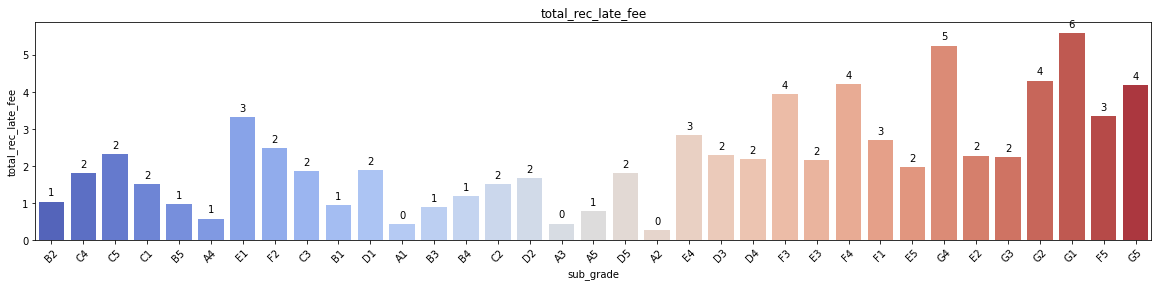

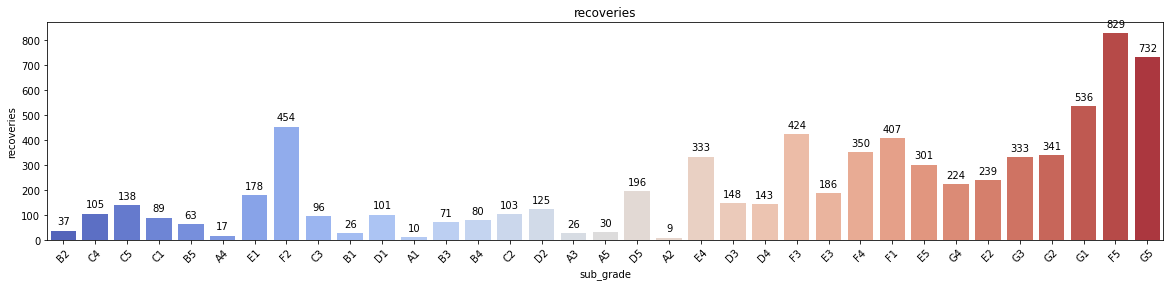

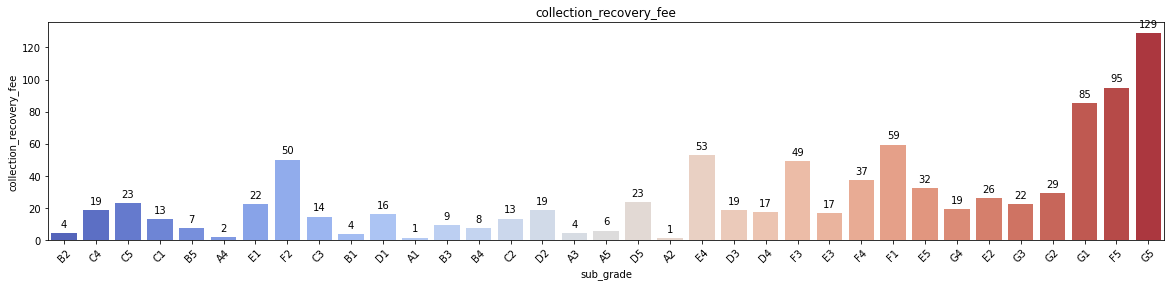

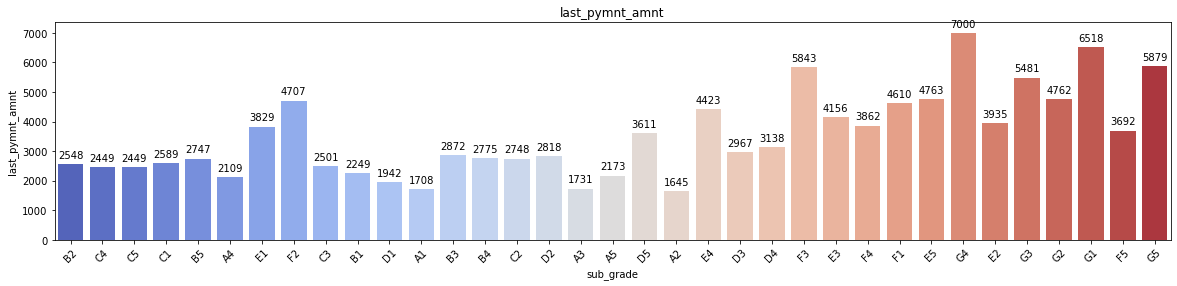

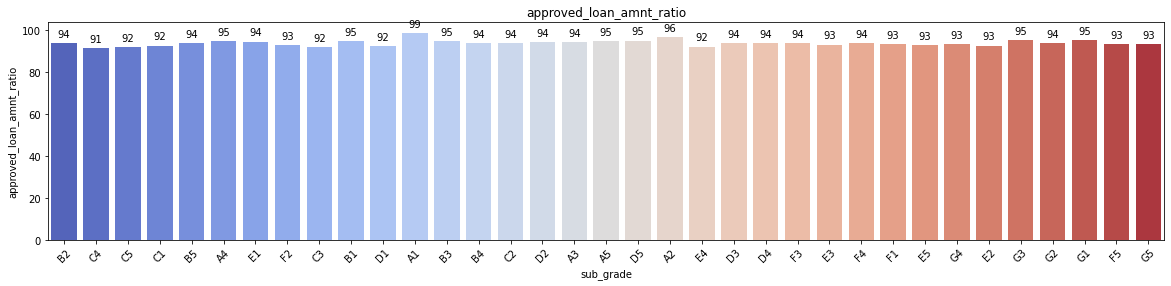

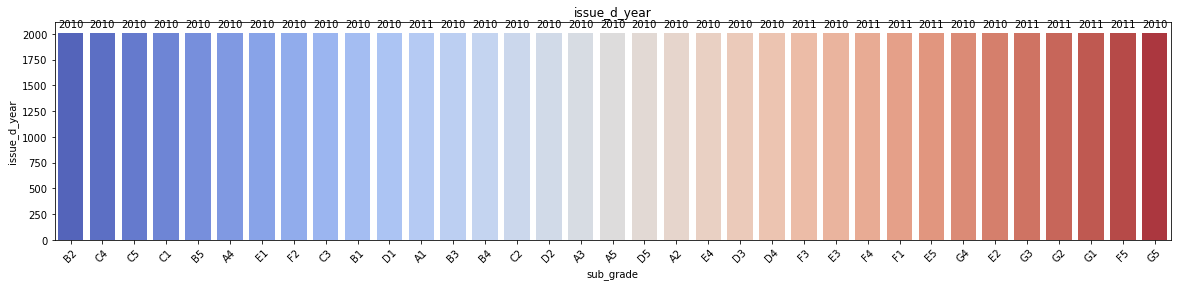

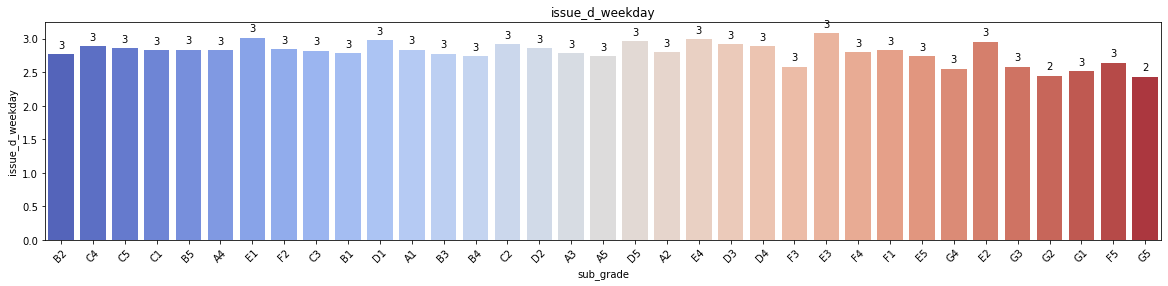

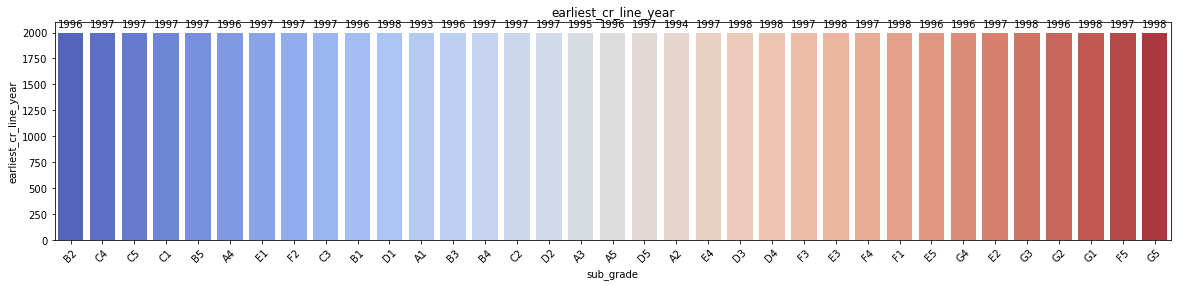

In [17]:
var = loan.columns[2:]
for i in var:
    plt.figure(figsize=(20,4))
    try:
        splot = sns.barplot(x='sub_grade', y=i, data=loan,  ci=None,  capsize=.2, palette='coolwarm')
        plt.title(str(i))
        
        for p in splot.patches:
            splot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points')
        plt.xticks(rotation=45)
       
    except Exception:
        plt.close()
        pass 

plt.show()

### In addition, we use addr_state variable to assess the bivariante impact. We noticed, that few states should not allowed with new loans. And, we recommend further detail understanding which exact locality / city is contributing to higher defaults, hence we should either penalized them with higher interest rate or altogether discourge new loans. 

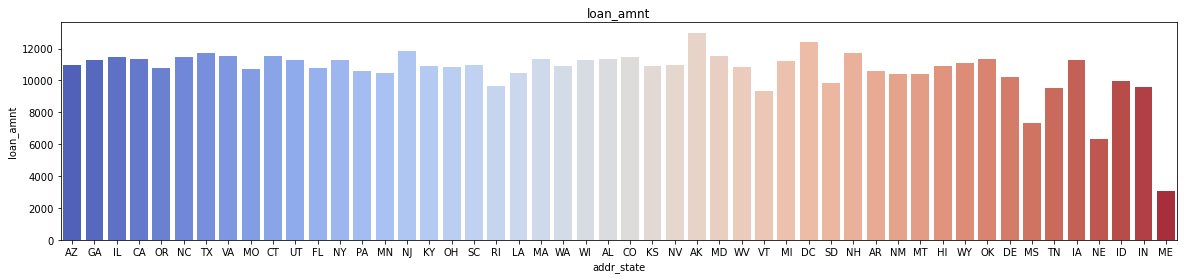

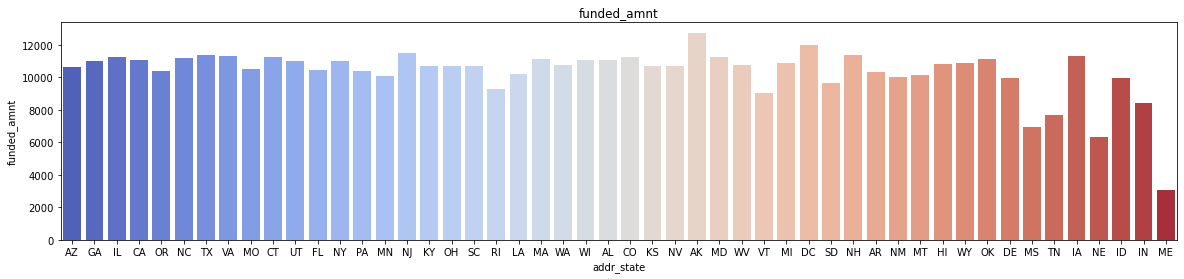

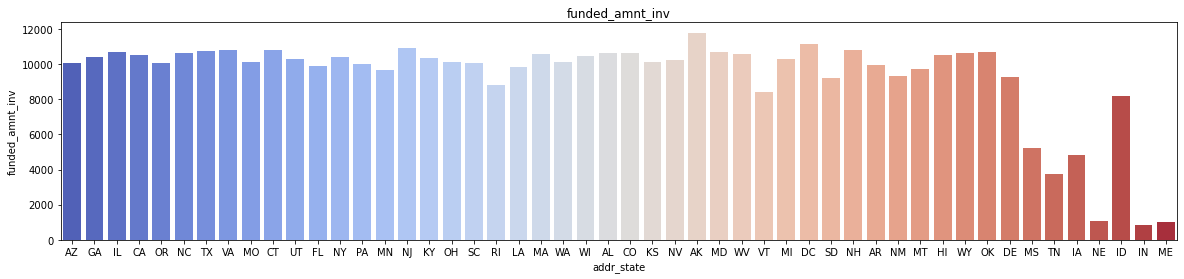

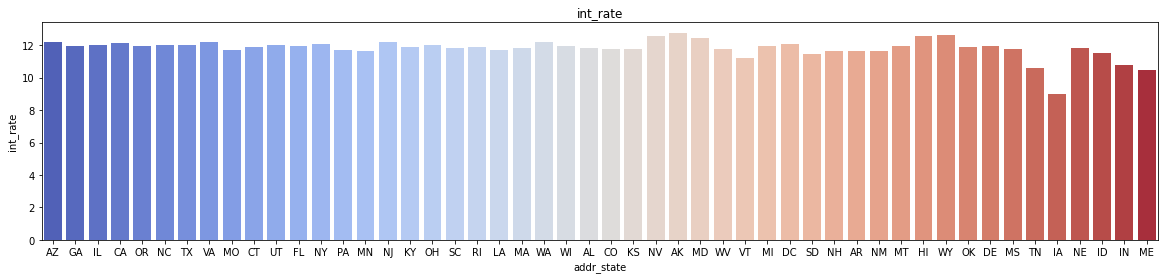

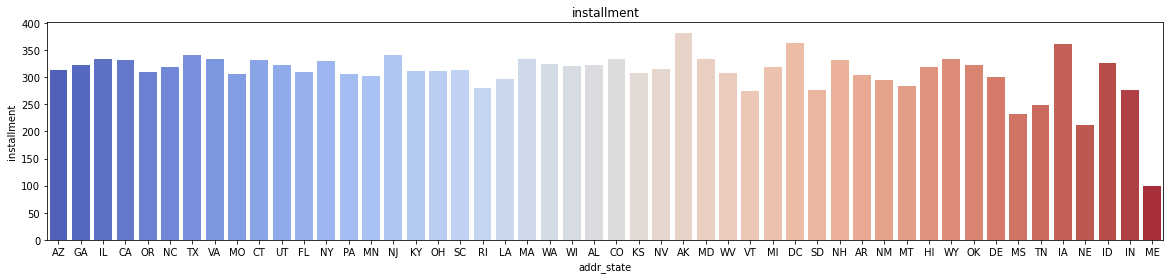

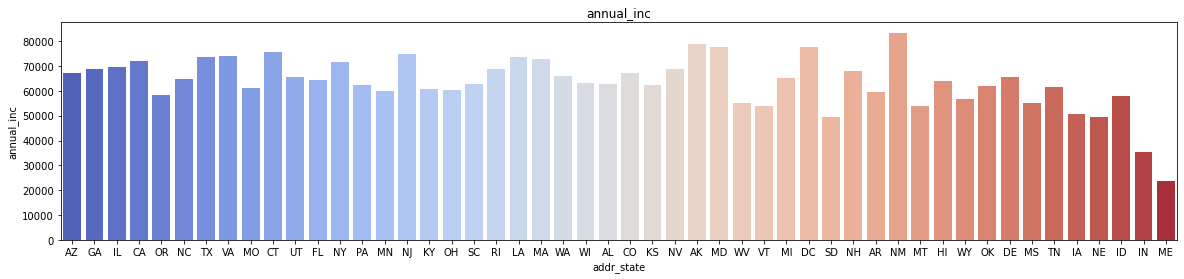

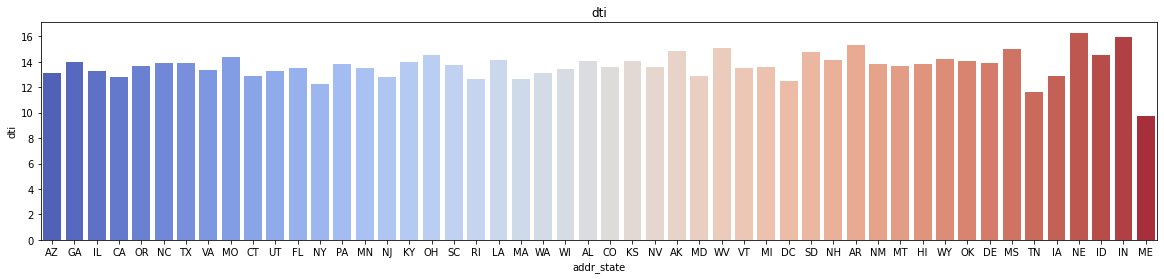

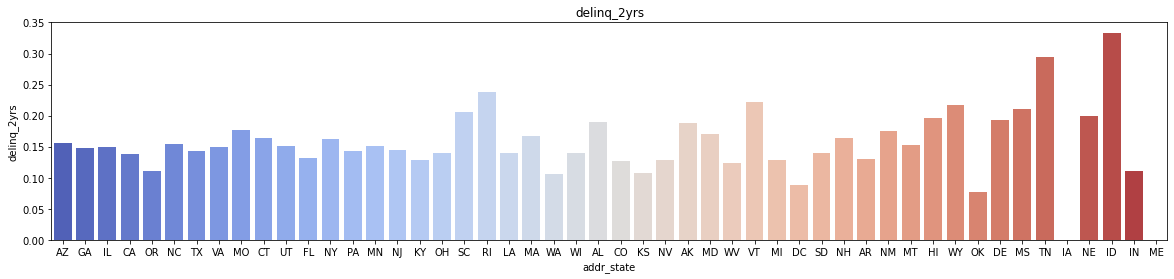

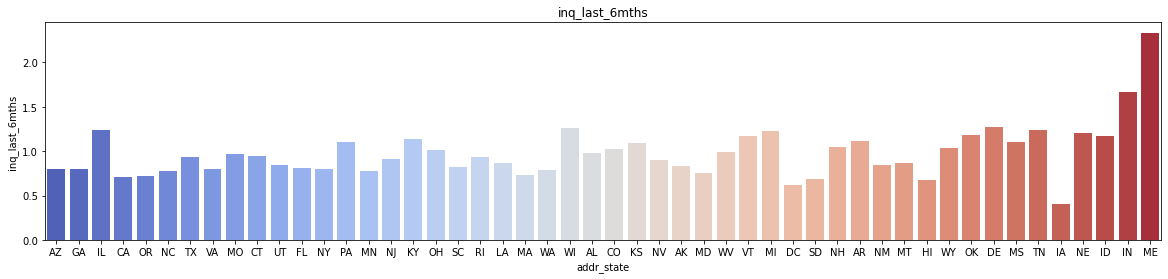

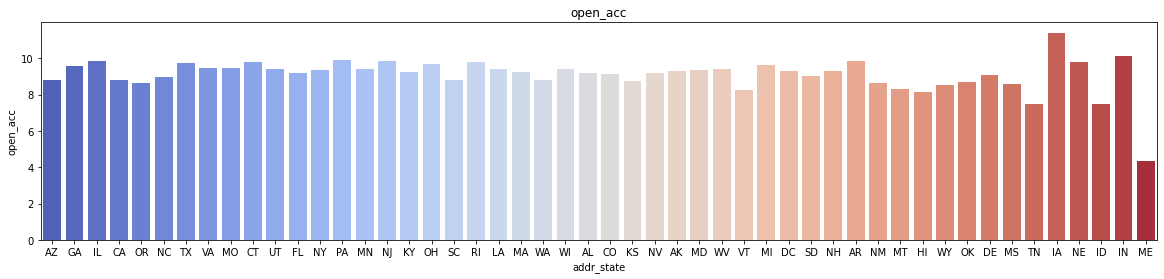

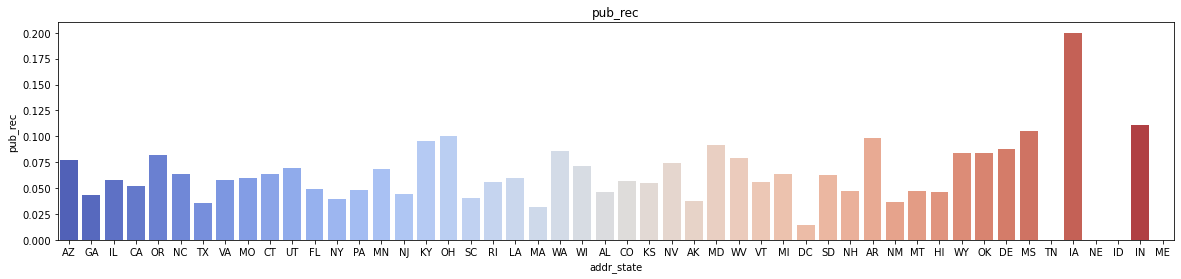

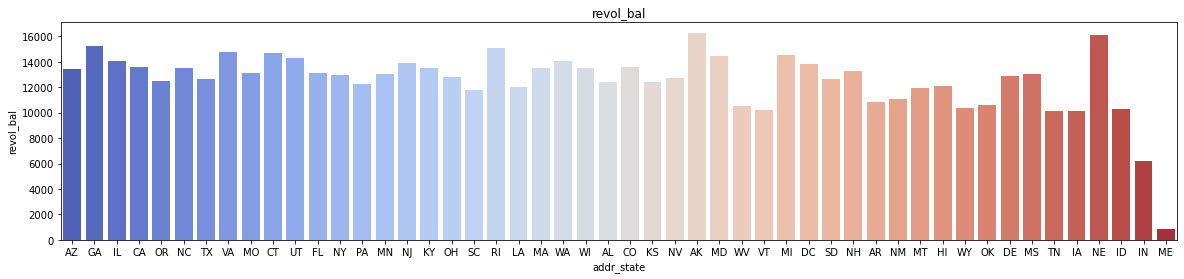

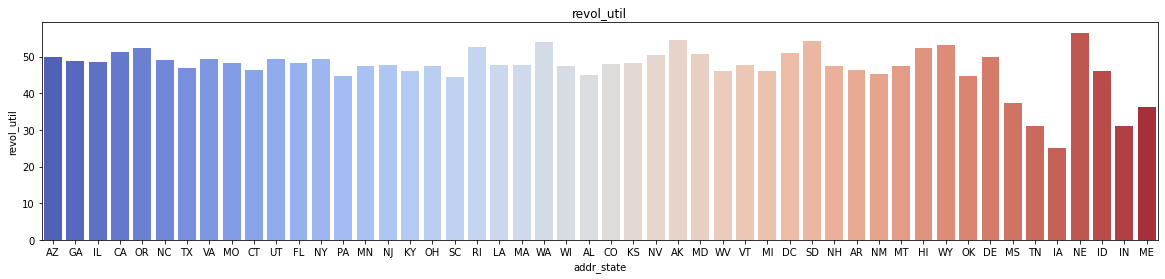

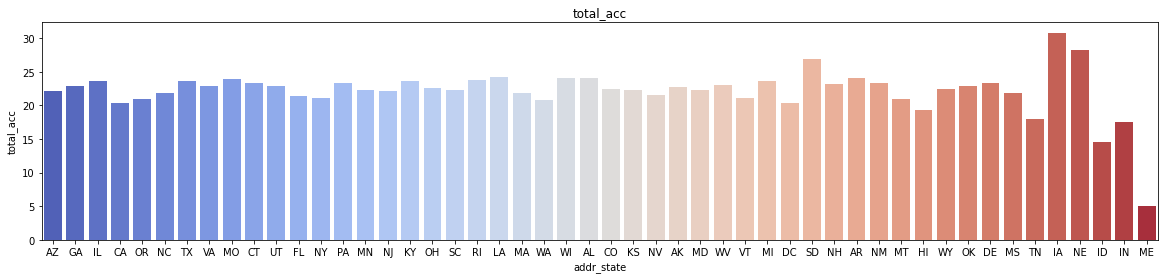

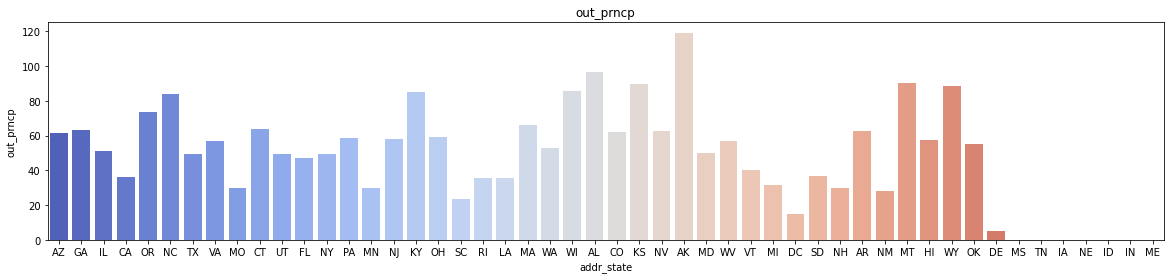

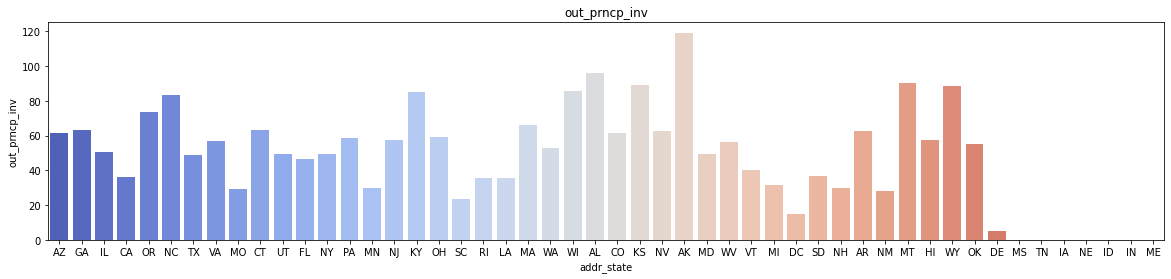

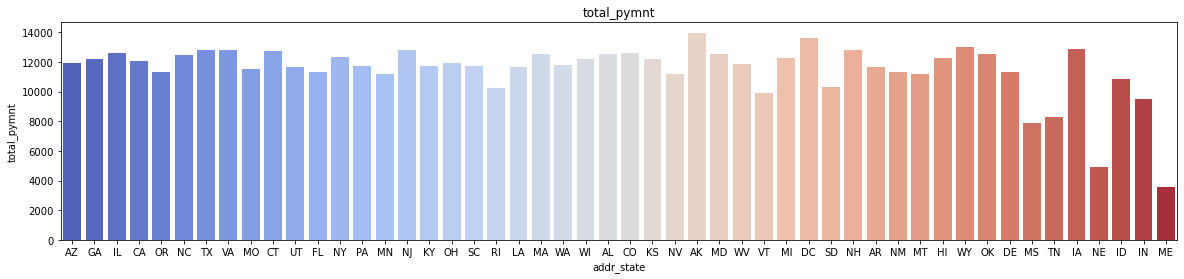

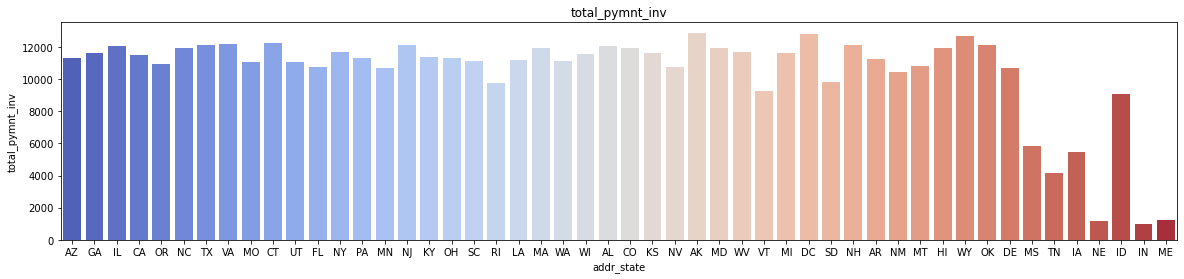

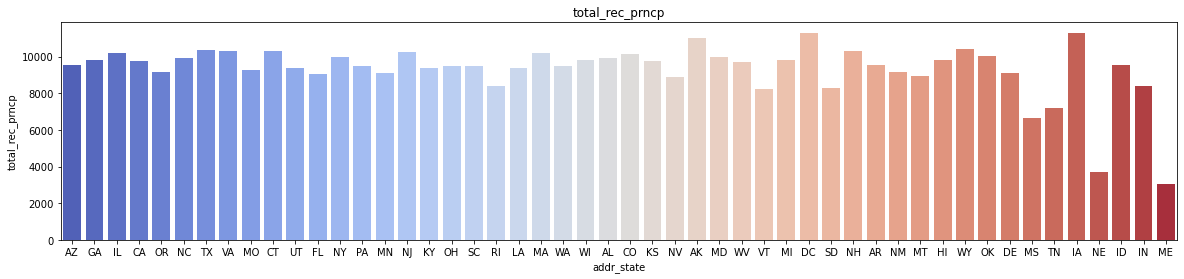

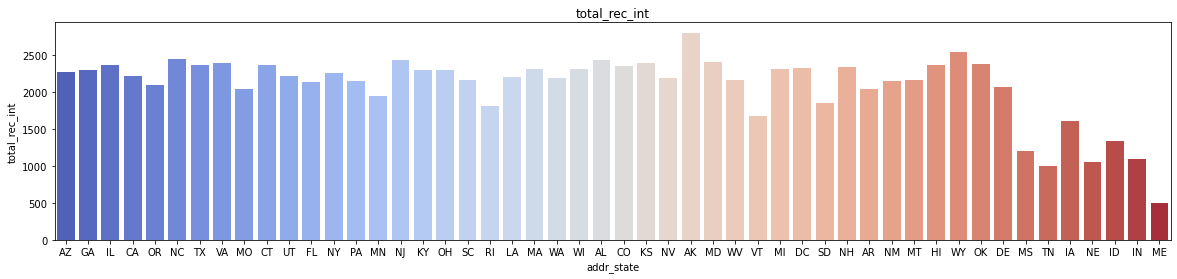

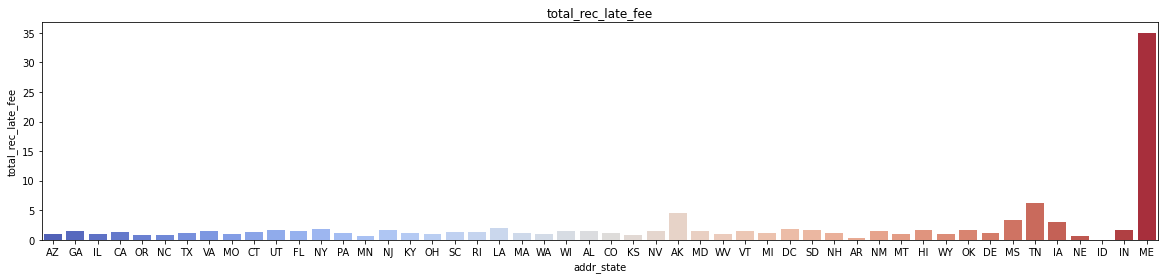

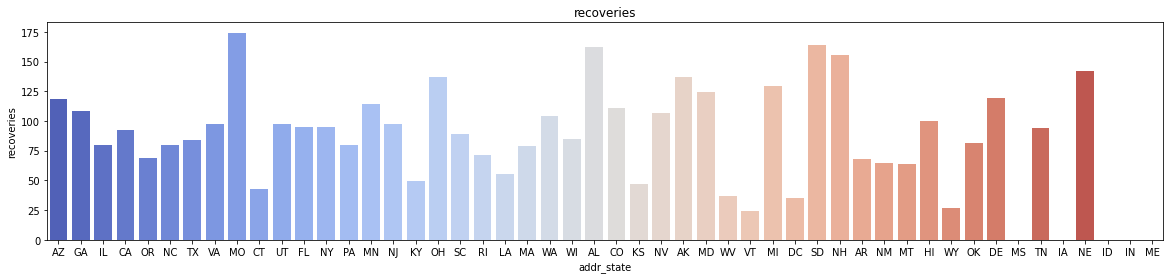

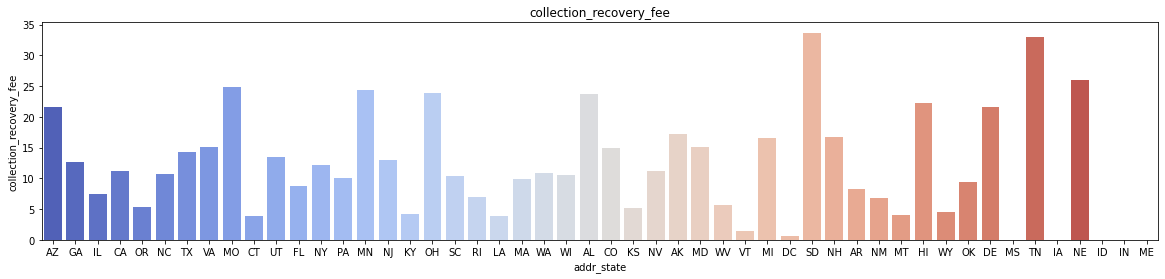

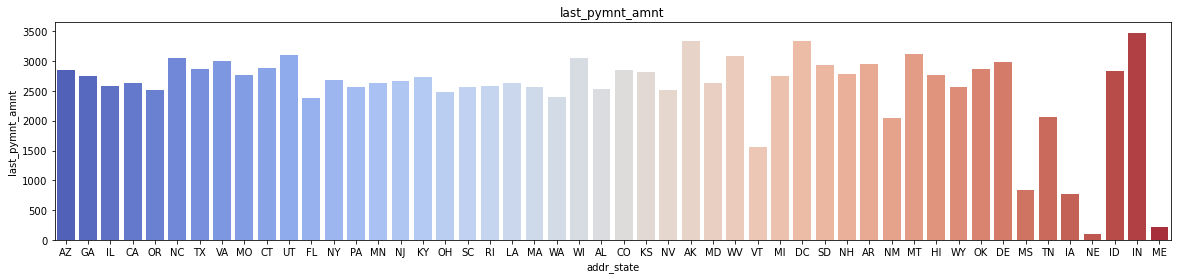

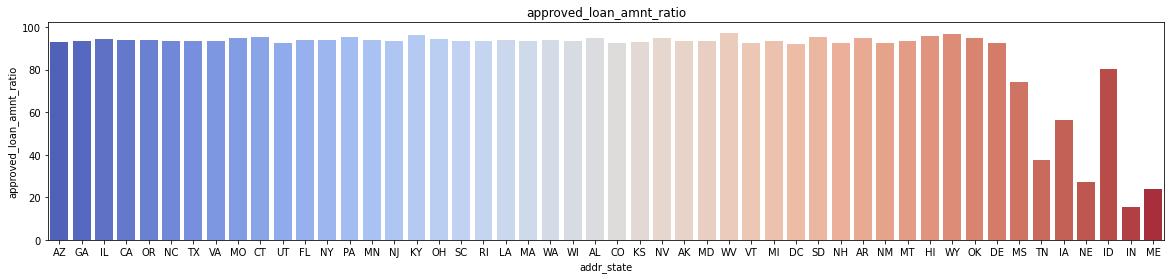

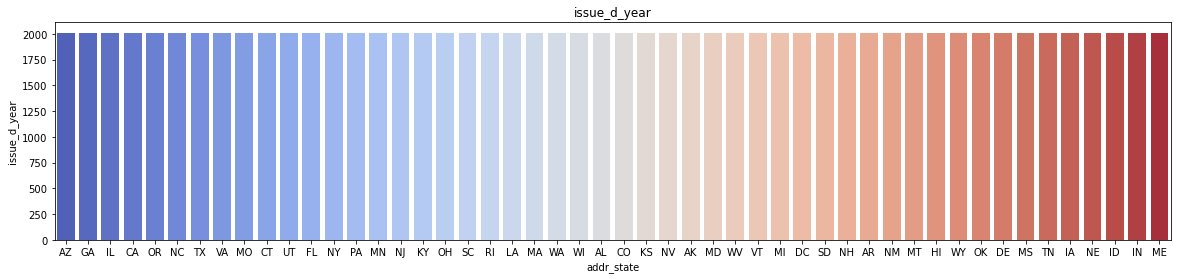

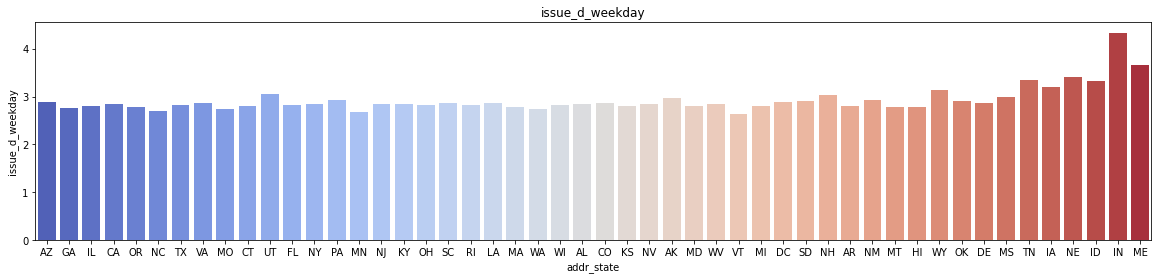

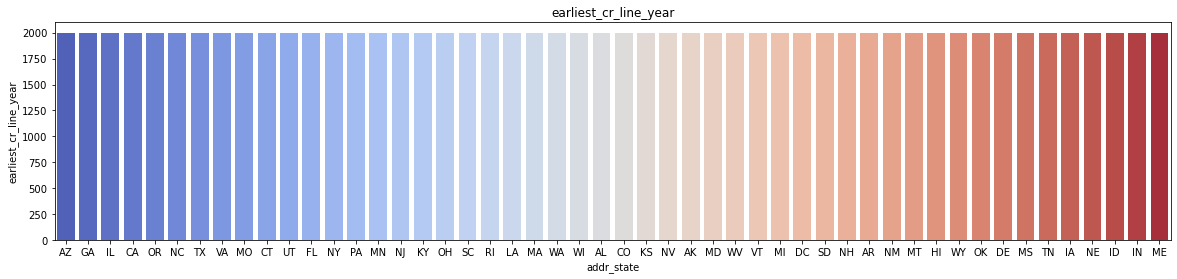

In [18]:
var = loan.columns[2:]
for i in var:
    plt.figure(figsize=(20,4))
    try:
        splot = sns.barplot(x='addr_state', y=i, data=loan,  ci=None,  capsize=.2, palette='coolwarm')
        plt.title(str(i))
        

       
    except Exception:
        plt.close()
        pass 

plt.show()

## Bivariate analysis by Correlation

### We compare the correlation of the variables (continues), it suggested few items like loan_amount, funded_amount and few others of positive correlation can be ignored, hence for any discreet analysis we can use loan_amount, similarly deliquency 2 year, recovery has negative correlation with loan_amount. Hence this suggested use to dig more details in EDA. 

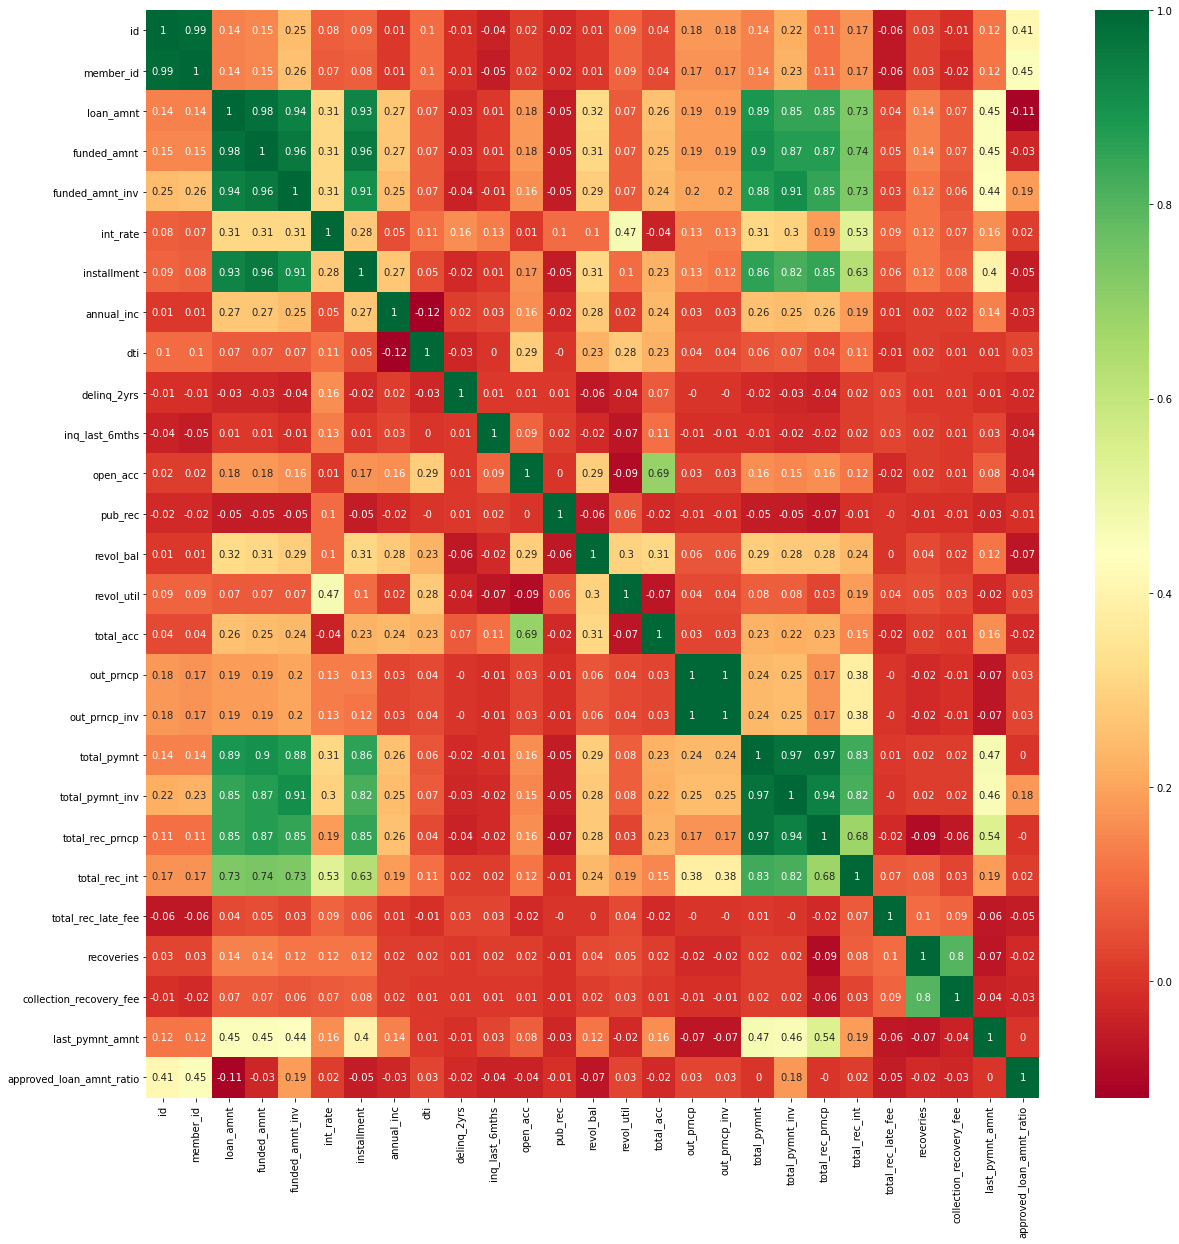

In [35]:
loan_corr_df = loan#.filter(["loan_amnt", "funded_amnt", "funded_amnt_inv",'int_rate_float','installment','emp_length','annual_inc','dti','l_t_ai']) 
cor = loan_corr_df.corr().round(2)
plt.figure(figsize=(20,20))
sns.heatmap(cor, cmap="RdYlGn", annot=True)
plt.savefig('correlation.jpeg')
plt.show()

### Applying the clustermap we clearly some large negative correlation clusters, when compared to loan amount.  

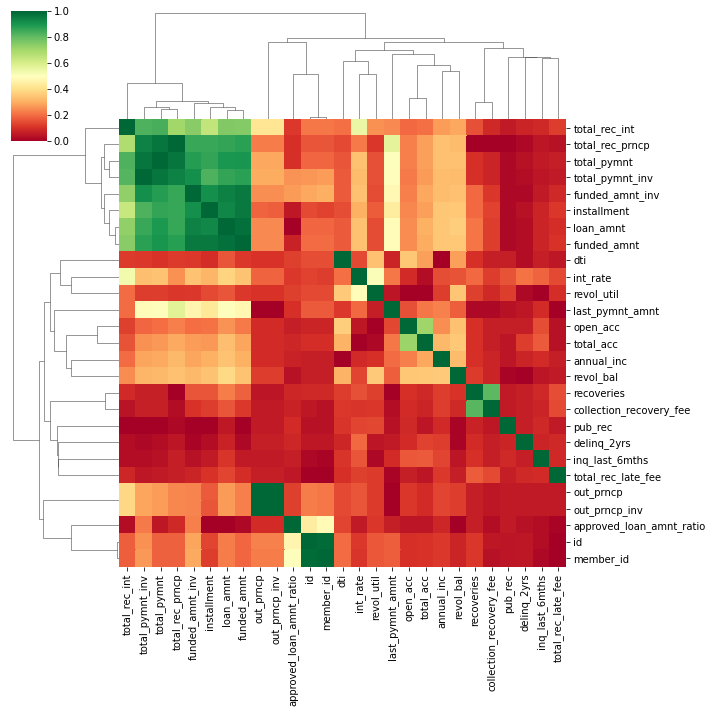

In [36]:
sns.clustermap(cor,cmap='RdYlGn',linecolor='white',standard_scale=1)
plt.savefig('clustermap.jpeg')

### we decided to analysed following key variables in HeatMap Correlation.   

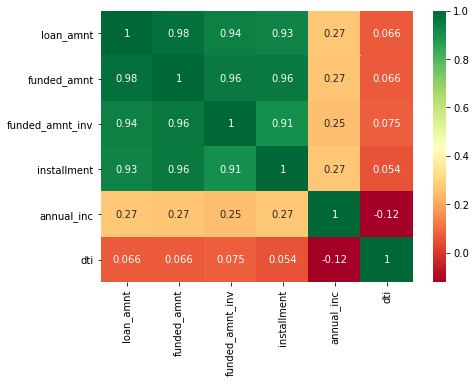

In [21]:
loan_corr_df = loan.filter(["loan_amnt", "funded_amnt", "funded_amnt_inv",'int_rate_float','installment','emp_length','annual_inc','dti','l_t_ai']) 
cor = loan_corr_df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(cor, cmap="RdYlGn", annot=True)
plt.show()

## Multivarite Analysis

### After our Univarite and Bivarinte analysis, we decided to investigate EDA by key variables which we noted in the above analysis.

We created a custom function to call two variables with further segementation. 

In [22]:
def call_analysis(x,y,hue=None, Pr=True):
    
    plt.figure(figsize=(20,4))
    
    try:
        splot = sns.barplot(x=x, y=y, data=loan,  capsize=.1, palette='coolwarm', hue=hue, ci=None)
        plt.title(str(x))
        if Pr == True:
            for p in splot.patches:
                splot.annotate(format(p.get_height(), '.0f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha = 'center', va = 'center', 
                               xytext = (0, 9), 
                               textcoords = 'offset points')
        plt.xticks(rotation=45)
    except Exception:
        plt.close()
        print("Error in Printing")
        pass 

    
    return plt.show()


### Employee Lenght with Loan Amount / Loan status, didn't suggest further.

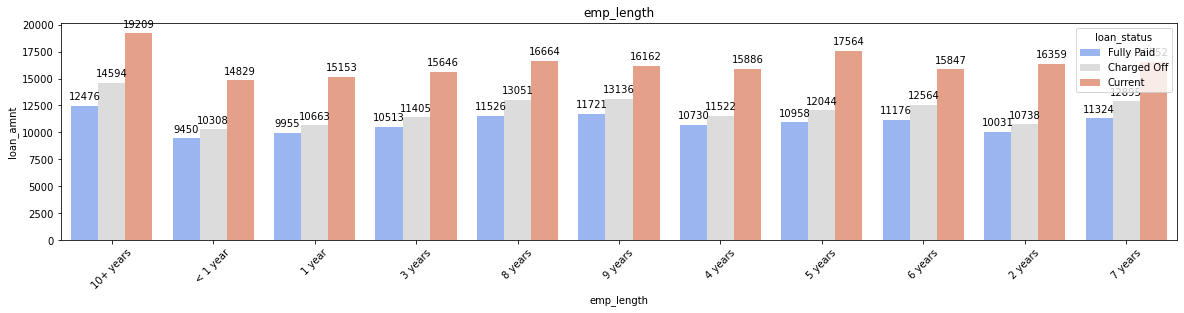

In [23]:
call_analysis('emp_length','loan_amnt','loan_status')

### When using purpose with Loan Amount & Loan Status, we noticed similar trend that highest charge-off was in Small Business, Debt Consolidation and Credit Cards. Hence, this suggested this purpose may need further insides and require Lending Club to set portfolio limits and may set high interest rates.

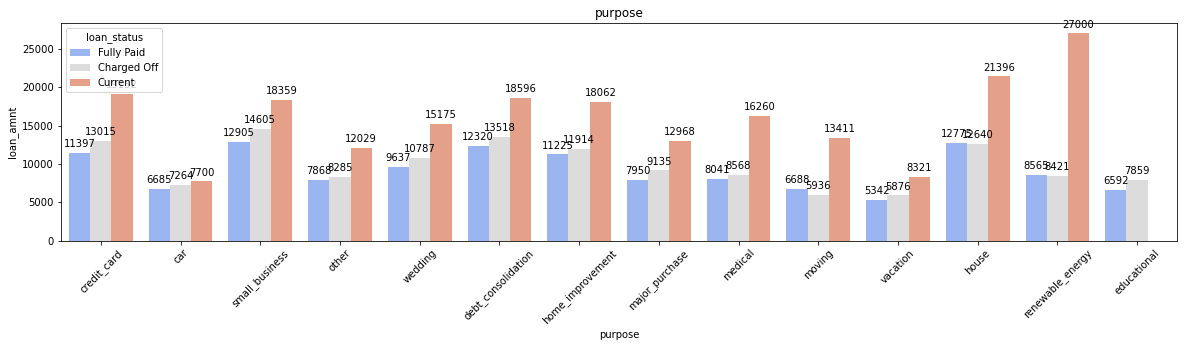

In [24]:
call_analysis('purpose','loan_amnt','loan_status')

### Delinqency 2 yr were highest in renewable energy sector. 

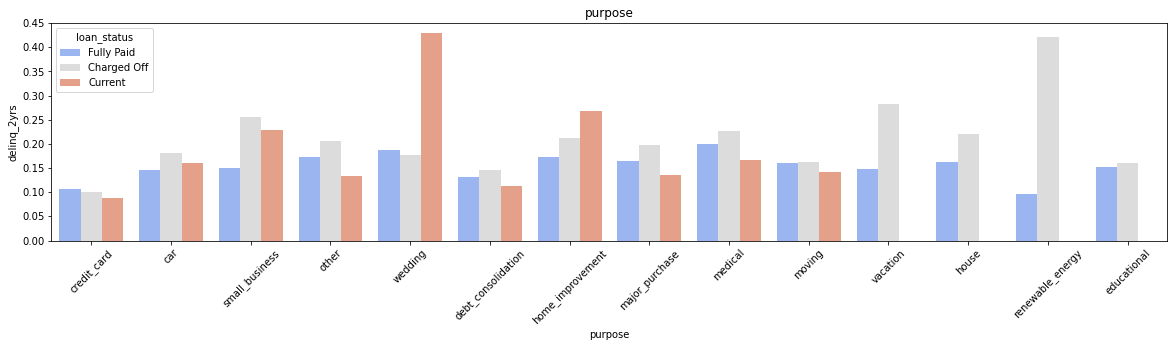

In [25]:
call_analysis('purpose','delinq_2yrs','loan_status',Pr=False)

### Similarly Verification status also confirmed, that not-verified custmers loan would have higher probability of defaulting due to higher delinquency rate.

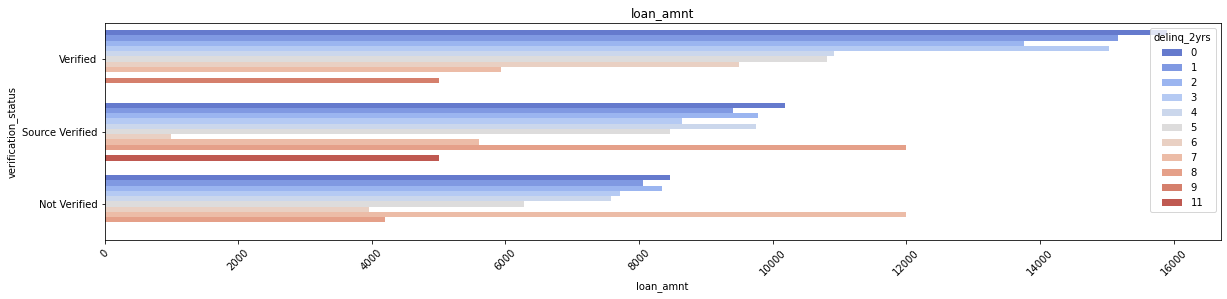

In [26]:
call_analysis('loan_amnt','verification_status','delinq_2yrs', Pr=False)

### it was very evident that lower employment yr would result in higher delinquency. Hence, Lending Club Policy should be at least for customers with proofable history of 3+ years is recommeded. As the 1st year tend to have high defaults.

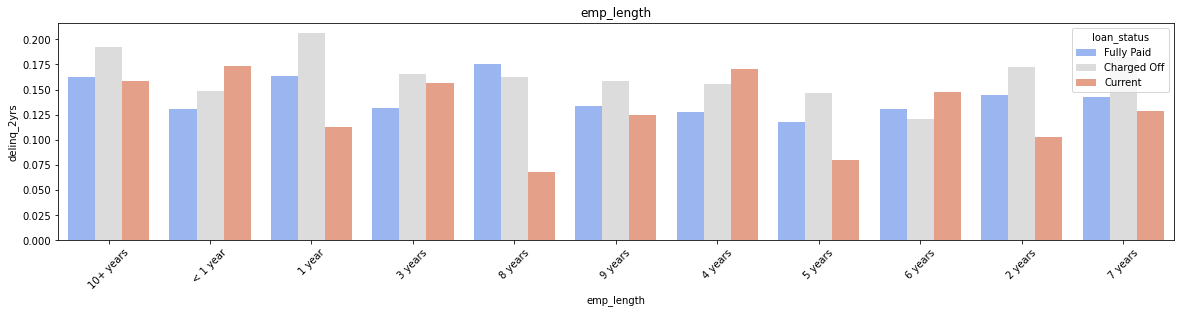

In [27]:
call_analysis('emp_length','delinq_2yrs','loan_status', Pr=False)

### Default orgin from certain states and address were higher, hence would need to cap limit and further invesitgate which addresses and city should be ban / have a temporary freeze to issuing new loans. 

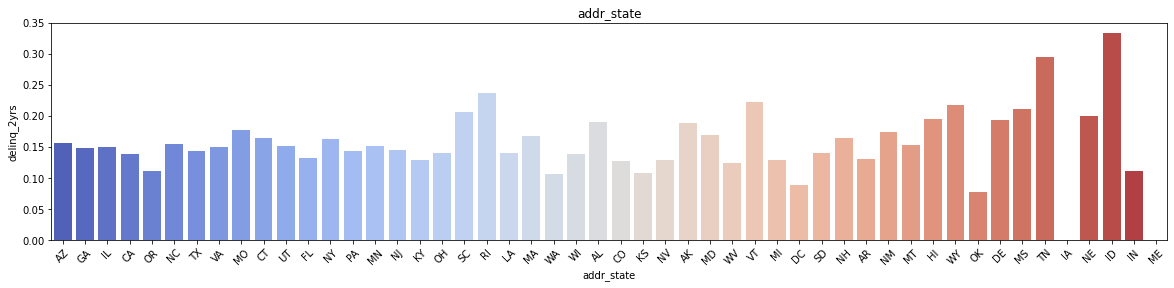

In [28]:
call_analysis('addr_state','delinq_2yrs', Pr=False) 

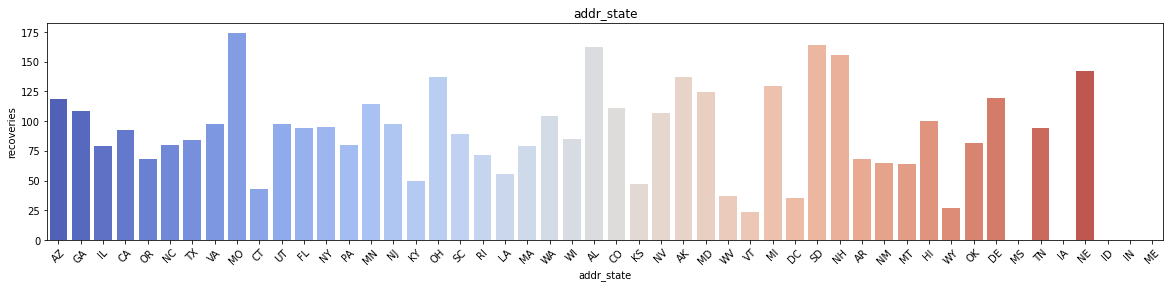

In [29]:
call_analysis('addr_state','recoveries', Pr=False) 

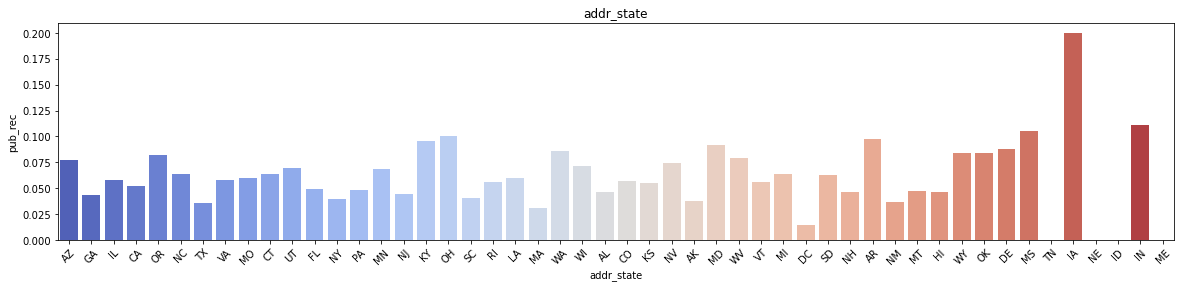

In [30]:
call_analysis('addr_state','pub_rec', Pr=False) 

### Lower Sub_grade also resulted in higher defaults, hence we recommend a cap any grade above D.

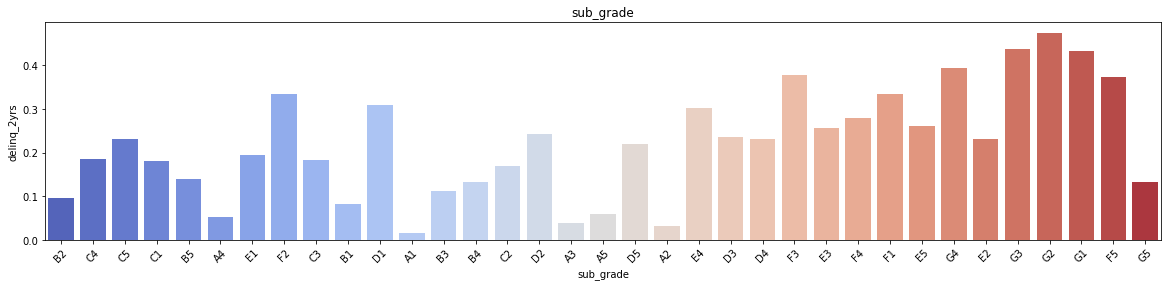

In [31]:
call_analysis('sub_grade','delinq_2yrs', Pr=False) 

### employee lenght, delinquecy and grade analysis suggested similar conclusion that discourging less than 3 years of employment history customers with loans.

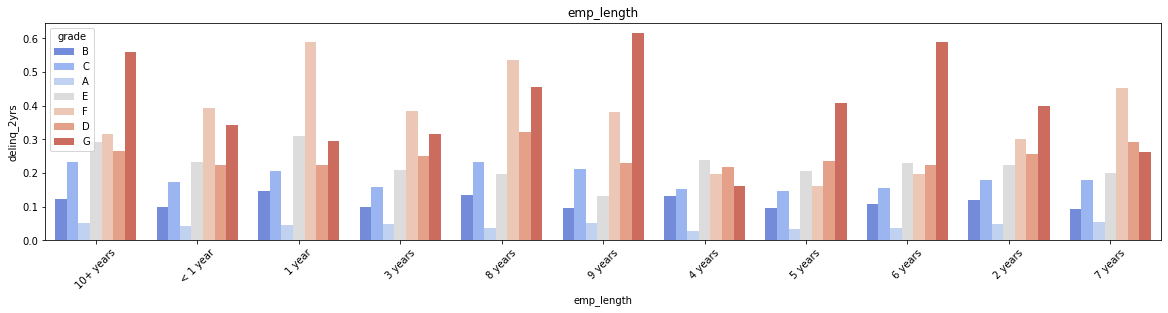

In [32]:
call_analysis('emp_length','delinq_2yrs','grade', Pr=False) 